In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
import pandas as pd
import sys

'''
src_path = sys.path[0].replace("figures\visualization\script", "src")
#replace notebook as scripts
data_path = sys.path[0].replace("figures\visualization\script", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("figures\visualization\script", "output")
'''

# set default params of plot
rc_={
    "figure.dpi":300,
    "font.size":10,
    "axes.facecolor":"white",
    "savefig.facecolor":"white",
    "text.usetex":True,
}
mpl.rcParams.update(rc_)

from XGBoost_helper import *

c:\Users\Lunlo\.conda\envs\XGBoost\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# load data

path='D:\Codes\GIthub_repo\Energy_grid\output\experiments\July2023_10_6h_step\LOG-MPC-MSC-6h-bat-step.xlsx'
df=pd.read_excel(path)

path_dc_line=r'D:\Codes\GIthub_repo\Energy_grid\output\experiments\Aug2023_debug2\debug_for_vi.xlsx'
df_dc_line=pd.read_excel(path_dc_line)

In [16]:
# process the original data
def pre_process(df,key):
    df.set_index('id')
    df=df[['strategy','pred_model','week_of_year',key]]
    df=df.replace('optimal',"MPC")
    df=df.replace("Simple","Heuristic")
    df['label']=df['strategy']+'-'+df['pred_model']

    for i in df['week_of_year'].unique():
        try:
            upper=df[((df['week_of_year']==i)) & (df['label']=='MSC-GT')][key].values[0]
            lower=df[((df['week_of_year']==i)) & (df['label']=='MPC-GT')][key].values[0]
            #assert upper>lower
            prediction=df[((df['week_of_year']==i)) & (df['label']=='MPC-Prediction')][key].values[0]
            heuristic=df[((df['week_of_year']==i)) & (df['label']=='MPC-Heuristic')][key].values[0]
            naive=df[((df['week_of_year']==i)) & (df['label']=='MPC-Naive')][key].values[0]
        except:
            pass
        
        upper_id=df[((df['week_of_year']==i)) & (df['label']=='MSC-GT')][key].index
        lower_id=df[((df['week_of_year']==i)) & (df['label']=='MPC-GT')][key].index
        prediction_id=df[((df['week_of_year']==i)) & (df['label']=='MPC-Prediction')][key].index
        heuristic_id=df[((df['week_of_year']==i)) & (df['label']=='MPC-Heuristic')][key].index
        naive_id=df[((df['week_of_year']==i)) & (df['label']=='MPC-Naive')][key].index 
        
        new_key='relative_'+key
        df.loc[lower_id,new_key]=0
        df.loc[upper_id,new_key]=100
        df.loc[prediction_id,new_key]=(prediction-lower)/(upper-lower)*100
        df.loc[heuristic_id,new_key]=(heuristic-lower)/(upper-lower)*100
        df.loc[naive_id,new_key]=(naive-lower)/(upper-lower)*100
    df_new=df.drop(df[df['label']=='MPC-Naive'].index)
    print(df_new)
    #df=df.reindex()
    invalid_week_list=df[(df_new[new_key]>100)|(df_new[new_key]<0)|(df_new[key].isna())].index
    invalid_week_list=df.iloc[invalid_week_list]['week_of_year'].unique()
    df['is_valid']=df['week_of_year'].apply(lambda x: True if x not in invalid_week_list else False)
    return df

def plot_origin(df,key,save_fn,fontsize):
    new_key='relative_'+key
    color_dict={
        'MPC-GT':'seagreen',
        'MPC-Prediction':'navy',
        'MPC-Heuristic':'steelblue',
        'MPC-Naive':'slategray',
        'MSC-GT':'orangered',
        'MSC-Naive':'grey'
    }
    fig,ax=plt.subplots(figsize=(20,5))

    scatter_x=np.array(df['week_of_year'])
    scatter_y=np.array(df[new_key])
    group=np.array(df['label'])
    #for i in range(len(df)):  
    for g in np.unique(group):
        i = np.where(group == g)
        ax.scatter(scatter_x[i], scatter_y[i], label=g,c=color_dict[g],\
            marker='_',s=250)
    ax.set_ylim([-20,120])
    #ax.xaxis.set_major_formatter
    ax.legend(fontsize=fontsize)
    plt.grid(axis = 'x')
    plt.show()
    
    if save_fn is not None:
        plt.savefig(save_fn)
        
def plot_valid(df,limit,figsize,save_fn,key,fontsize):
    new_key='relative_'+key
    df_valid=df.drop(df[df.is_valid==False].index)

    x_coor=np.array([df_valid[df_valid.label=='MPC-Prediction']['week_of_year'],\
        df_valid[df_valid.label=='MPC-Prediction']['week_of_year']])

    y_coor=np.array([df_valid[df_valid.label=='MPC-Heuristic'][new_key],\
        df_valid[df_valid.label=='MPC-Prediction'][new_key]])

    color_dict={
        'MPC-GT':'seagreen',
        'MPC-Prediction':'navy',
        'MPC-Heuristic':'steelblue',
        'MPC-Naive':'gainsboro',
        'MSC-GT':'orangered',
        'MSC-Naive':'grey'
    }
    maker_dict={
        'MPC-GT':'_',
        'MPC-Prediction':'_',
        'MPC-Heuristic':'_',
        'MPC-Naive':'_',
        'MSC-GT':'_',
        'MSC-Naive':'_'
    }

    fig,ax=plt.subplots(figsize=figsize)

    scatter_x=np.array(df_valid['week_of_year'])
    scatter_y=np.array(df_valid[new_key])
    is_valid=np.array(df_valid['is_valid'])
    group=np.array(df_valid['label'])
    label_x=[]
    for i in scatter_x: 
        label_x.append('Week '+str(i))

    ax.set_xticks(ticks=scatter_x)
    ax.set_xticklabels(labels=label_x,fontsize=fontsize,rotation=45)

    for g in np.unique(group):
        i = np.where(group == g)
        ax.scatter(scatter_x[i], scatter_y[i], label=g,c=color_dict[g],\
            marker=maker_dict[g],s=250)
    ax.set_ylim(limit)
    ax.legend(loc='upper left',bbox_to_anchor=(1.02,1),fontsize=fontsize)

    for i in range(len(x_coor[0])):
        ax.bar(x=x_coor[0][i],height=np.abs(y_coor[0][i]-y_coor[1][i]), \
            bottom=min(y_coor[0][i],y_coor[1][i]),color='lightsteelblue',width=0.6,alpha=0.3)
    ax.set_xlabel("Weeks in the year of 2019",fontsize=fontsize*1.5)
    ax.set_ylabel("Relative "+key+" (Percentage)",fontsize=fontsize*1.5)


    ax.set_title("Relative "+key+" of Different Models",fontsize=fontsize*1.5)
    ax.text(s="Notes: 1. "+key+" under MPC-GT is marked as lower bound while MSC_GT marked as upper bound \n  \
                    \t   2. Data sets which don't meet our expection that MPC-GT is upper bound and MSC-GT is lower bound were removed.",
            fontsize=fontsize*1.2,
            x=0,
            y=-40
            )
    #ax.grid(True)
    plt.grid(axis = 'x',linestyle='--',alpha=0.1)
    plt.grid(axis = 'y',linestyle='--',alpha=0.8)
    plt.savefig(save_fn)
    plt.show()
    
    if save_fn is not None:
        plt.savefig(save_fn)
    
def plot_origin_valid_bar(df,limit,figsize,key,save_fn,fontsize):
    new_key='relative_'+key
    df_valid=df.drop(df[df.is_valid==False].index)

    x_coor=np.array([df_valid[df_valid.label=='MPC-Prediction']['week_of_year'],\
        df_valid[df_valid.label=='MPC-Prediction']['week_of_year']])

    y_coor=np.array([df_valid[df_valid.label=='MPC-Heuristic'][new_key],\
        df_valid[df_valid.label=='MPC-Prediction'][new_key]])
    
    color_dict={
        'MPC-GT':'seagreen',
        'MPC-Prediction':'navy',
        'MPC-Heuristic':'steelblue',
        'MPC-Naive':'gainsboro',
        'MSC-GT':'orangered',
        'MSC-Naive':'grey'
    }
    maker_dict={
        'MPC-GT':'_',
        'MPC-Prediction':'_',
        'MPC-Heuristic':'_',
        'MPC-Naive':'_',
        'MSC-GT':'_',
        'MSC-Naive':'_'
    }

    fig,ax=plt.subplots(figsize=figsize)
    scatter_x=np.array(df['week_of_year'])
    scatter_y=np.array(df[new_key])

    group=np.array(df['label'])
    label_x=[]
    for i in scatter_x: 
        label_x.append('Week '+str(i))
    ax.set_xticks(ticks=scatter_x)
    ax.set_xticklabels(labels=label_x,fontsize=fontsize,rotation=45)

    for g in np.unique(group):
        i = np.where(group == g)
        ax.scatter(scatter_x[i], scatter_y[i], label=g,c=color_dict[g],\
            marker=maker_dict[g],s=250)
    ax.set_ylim(limit)
    ax.legend(loc='upper left',bbox_to_anchor=(1.02,1),fontsize=fontsize)
    

    for i in range(len(x_coor[0])):
        ax.bar(x=x_coor[0][i],height=np.abs(y_coor[0][i]-y_coor[1][i]), \
            bottom=min(y_coor[0][i],y_coor[1][i]),color='lightsteelblue',width=0.6,alpha=0.3)
        
    ax.set_xlabel("Weeks in the year of 2019",fontsize=fontsize*1.5)
    ax.set_ylabel("Relative "+key+" (Percentage)",fontsize=fontsize*1.5)


    ax.set_title("Relative "+key+" of Different Models",fontsize=fontsize*1.5)
    ax.text(s="Notes: 1. "+key+" under MPC-GT is marked as lower bound while MSC_GT marked as upper bound.",
            fontsize=fontsize*1.2,
            x=0,
            y=-40
            )
    #ax.grid(True)
    plt.grid(axis = 'x',linestyle='--',alpha=0.1)
    plt.grid(axis = 'y',linestyle='--',alpha=0.8)
    plt.savefig(save_fn)
    plt.show()
    
    if save_fn is not None:
        plt.savefig(save_fn)
        
def pre_process_dc_line(df):
    df=df.rename(columns={"grid_max":"mpc_grid_max", "OPEX":"mpc_opex","tou_cost":"mpc_tou_cost"})
    df['label']=df['start']+" to "+df["end"]
    df_gruoped=df.groupby("label")
    return df_gruoped

def plot_dc_line_group(df,plot_key_list_x,plot_key_list_y,x_key,suptitle,base_size):
    #plt.subplots()
    x_i_p=len(plot_key_list_x)
    y_i_p=len(plot_key_list_y)
    plt.subplots(y_i_p,x_i_p,sharex="col",sharey='row',figsize=base_size,)
    n=1
    y_i=1
    for s_y in plot_key_list_y:
        
        x_i=1
        for s_x in plot_key_list_x:
            x=df.get_group(s_x)[x_key]
            x_label=[]
            for l in x:
                x_label.append(str(l))
            y_mpc=df.get_group(s_x)['mpc_'+s_y]
            y_rbc=df.get_group(s_x)['rbc_'+s_y]
            ax=plt.subplot(y_i_p,x_i_p, n)
            ax.set_xticks(x)
            ax.set_xticklabels(x_label,rotation=45)
            ax.grid(axis='x',color='lightgray',linestyle="--")
            plt.scatter(x,y_mpc,color="seagreen",label="MPC",marker='x')
            plt.scatter(x,y_rbc,color="orangered",label="RBC",marker='.')
            if n==1:
                plt.legend()
            plt.plot(x,y_mpc,color="seagreen",alpha=0.7)
            plt.plot(x,y_rbc,color="orangered",alpha=0.7)

            if y_i==y_i_p:
                ax.set_xlabel(x_key,fontsize=15)
            if x_i==1:
                ax.set_ylabel(s_y,fontsize=15)
            
            if y_i==1:
                plt.title(str(s_x))
            x_i+=1
            n+=1
        y_i+=1
    
    plt.suptitle(suptitle,fontsize=18)
    plt.tight_layout()
    
    #plt.figsize([base_size[0]*len(plot_key_list_x),base_size[1]*len(plot_key_list_y)])
    plt.show()

In [38]:
df_dc=pre_process_dc_line(df_dc_line)
df_temp=df_dc.get_group('2-1-0-0 to 2-2-0-0')

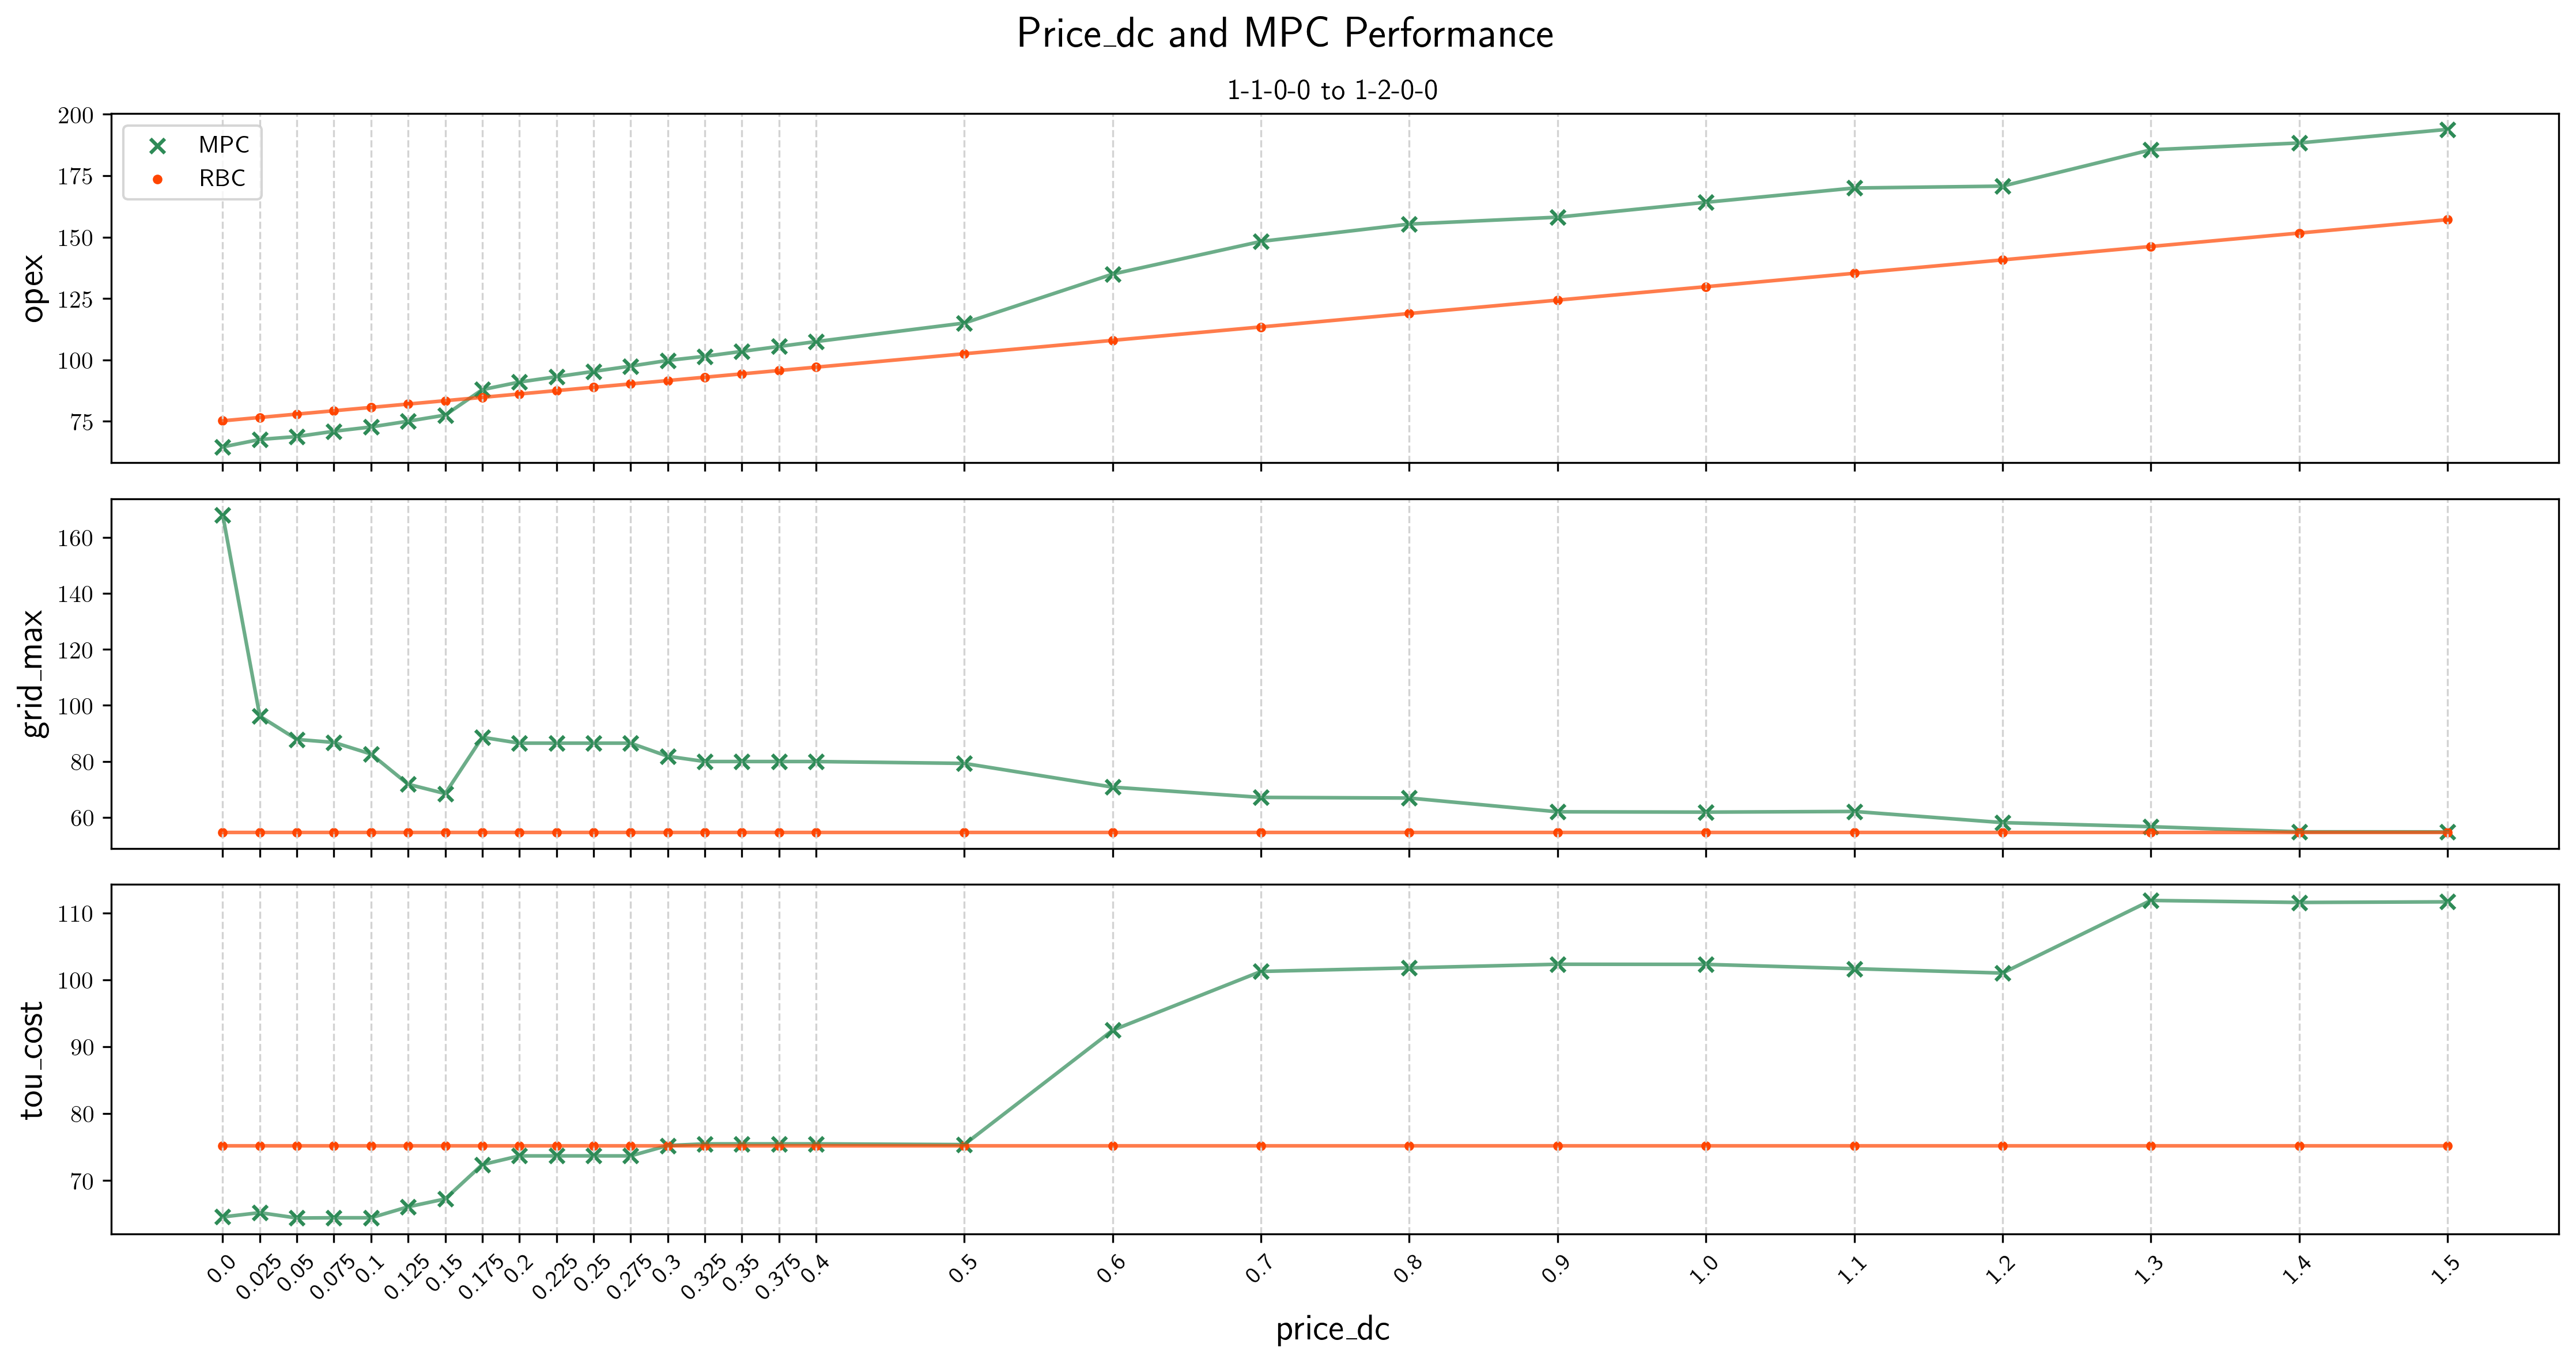

In [44]:

plot_dc_line_group(df_dc,
                   ['1-1-0-0 to 1-2-0-0'],
                   ['opex','grid_max','tou_cost'],
                   'price_dc',
                   "Price_dc and MPC Performance",
                   [15,8])

In [78]:
len(['07-01 to 07-08','08-01 to 08-08','09-01 to 09-08'])

3

In [58]:
df=pre_process(df,'OPEX')

    strategy  pred_model  week_of_year        OPEX           label  \
0        MSC          GT             1  255.510288          MSC-GT   
2        MPC   Heuristic             1  241.622925   MPC-Heuristic   
3        MPC  Prediction             1  245.566423  MPC-Prediction   
4        MPC          GT             1  223.609240          MPC-GT   
5        MSC          GT             2  408.736072          MSC-GT   
..       ...         ...           ...         ...             ...   
254      MPC          GT            51  305.676962          MPC-GT   
255      MSC          GT            52  173.690170          MSC-GT   
257      MPC   Heuristic            52  178.356166   MPC-Heuristic   
258      MPC  Prediction            52  175.561454  MPC-Prediction   
259      MPC          GT            52  163.673667          MPC-GT   

     relative_OPEX  
0       100.000000  
2        56.467376  
3        68.829034  
4         0.000000  
5       100.000000  
..             ...  
254       0.

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_12524\1226988837.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  invalid_week_list=df[(df_new[new_key]>100)|(df_new[new_key]<0)|(df_new[key].isna())].index


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [48]:
df

,strategy,pred_model,week_of_year,OPEX,label,relative_OPEX,is_valid
0,MSC,GT,1,255.510288,MSC-GT,100.000000,True
1,MPC,Naive,1,230.584804,MPC-Naive,21.866253,True
2,MPC,Heuristic,1,241.622925,MPC-Heuristic,56.467376,True
3,MPC,Prediction,1,245.566423,MPC-Prediction,68.829034,True
4,MPC,GT,1,223.609240,MPC-GT,0.000000,True
...,...,...,...,...,...,...,...
255,MSC,GT,52,173.690170,MSC-GT,100.000000,False
256,MPC,Naive,52,171.696000,MPC-Naive,80.091156,False
257,MPC,Heuristic,52,178.356166,MPC-Heuristic,146.583091,False
258,MPC,Prediction,52,175.561454,MPC-Prediction,118.682019,False


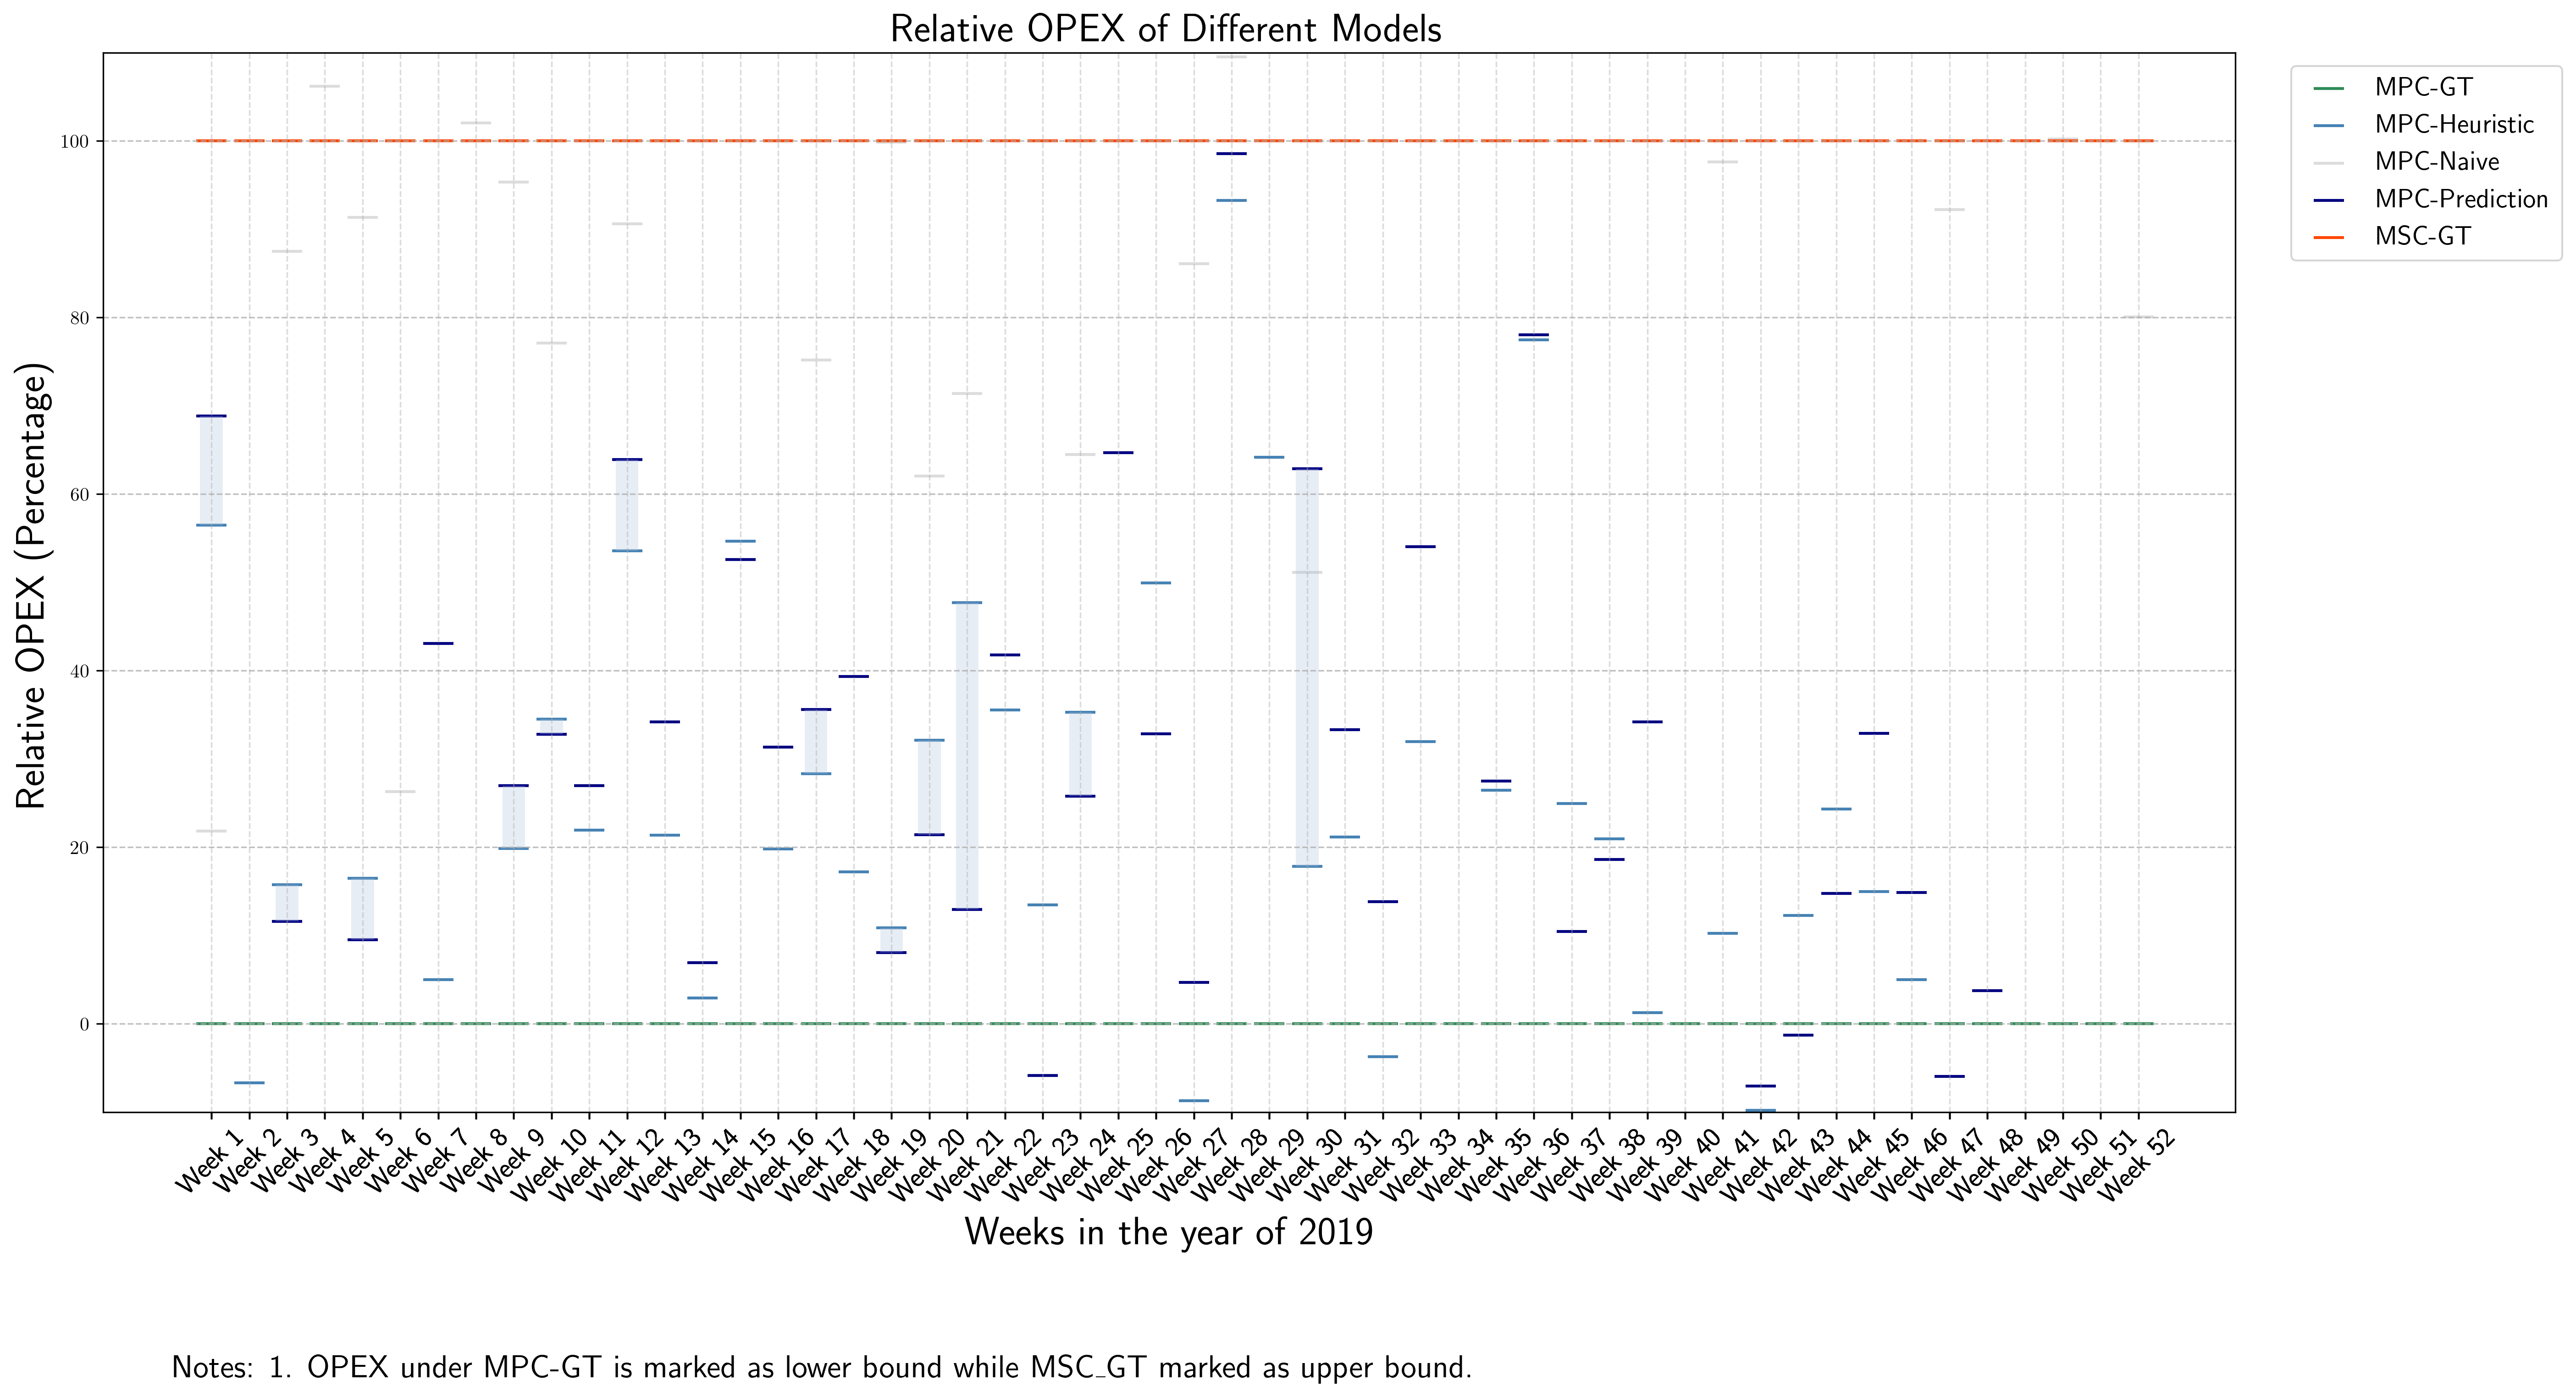

<Figure size 1920x1440 with 0 Axes>

In [25]:
limit=[-10,110]
figsize=(20,10)
plot_origin_valid_bar(df,limit,figsize,'OPEX','relative_opex_byweek_orgin_dc_formulation.png',14)

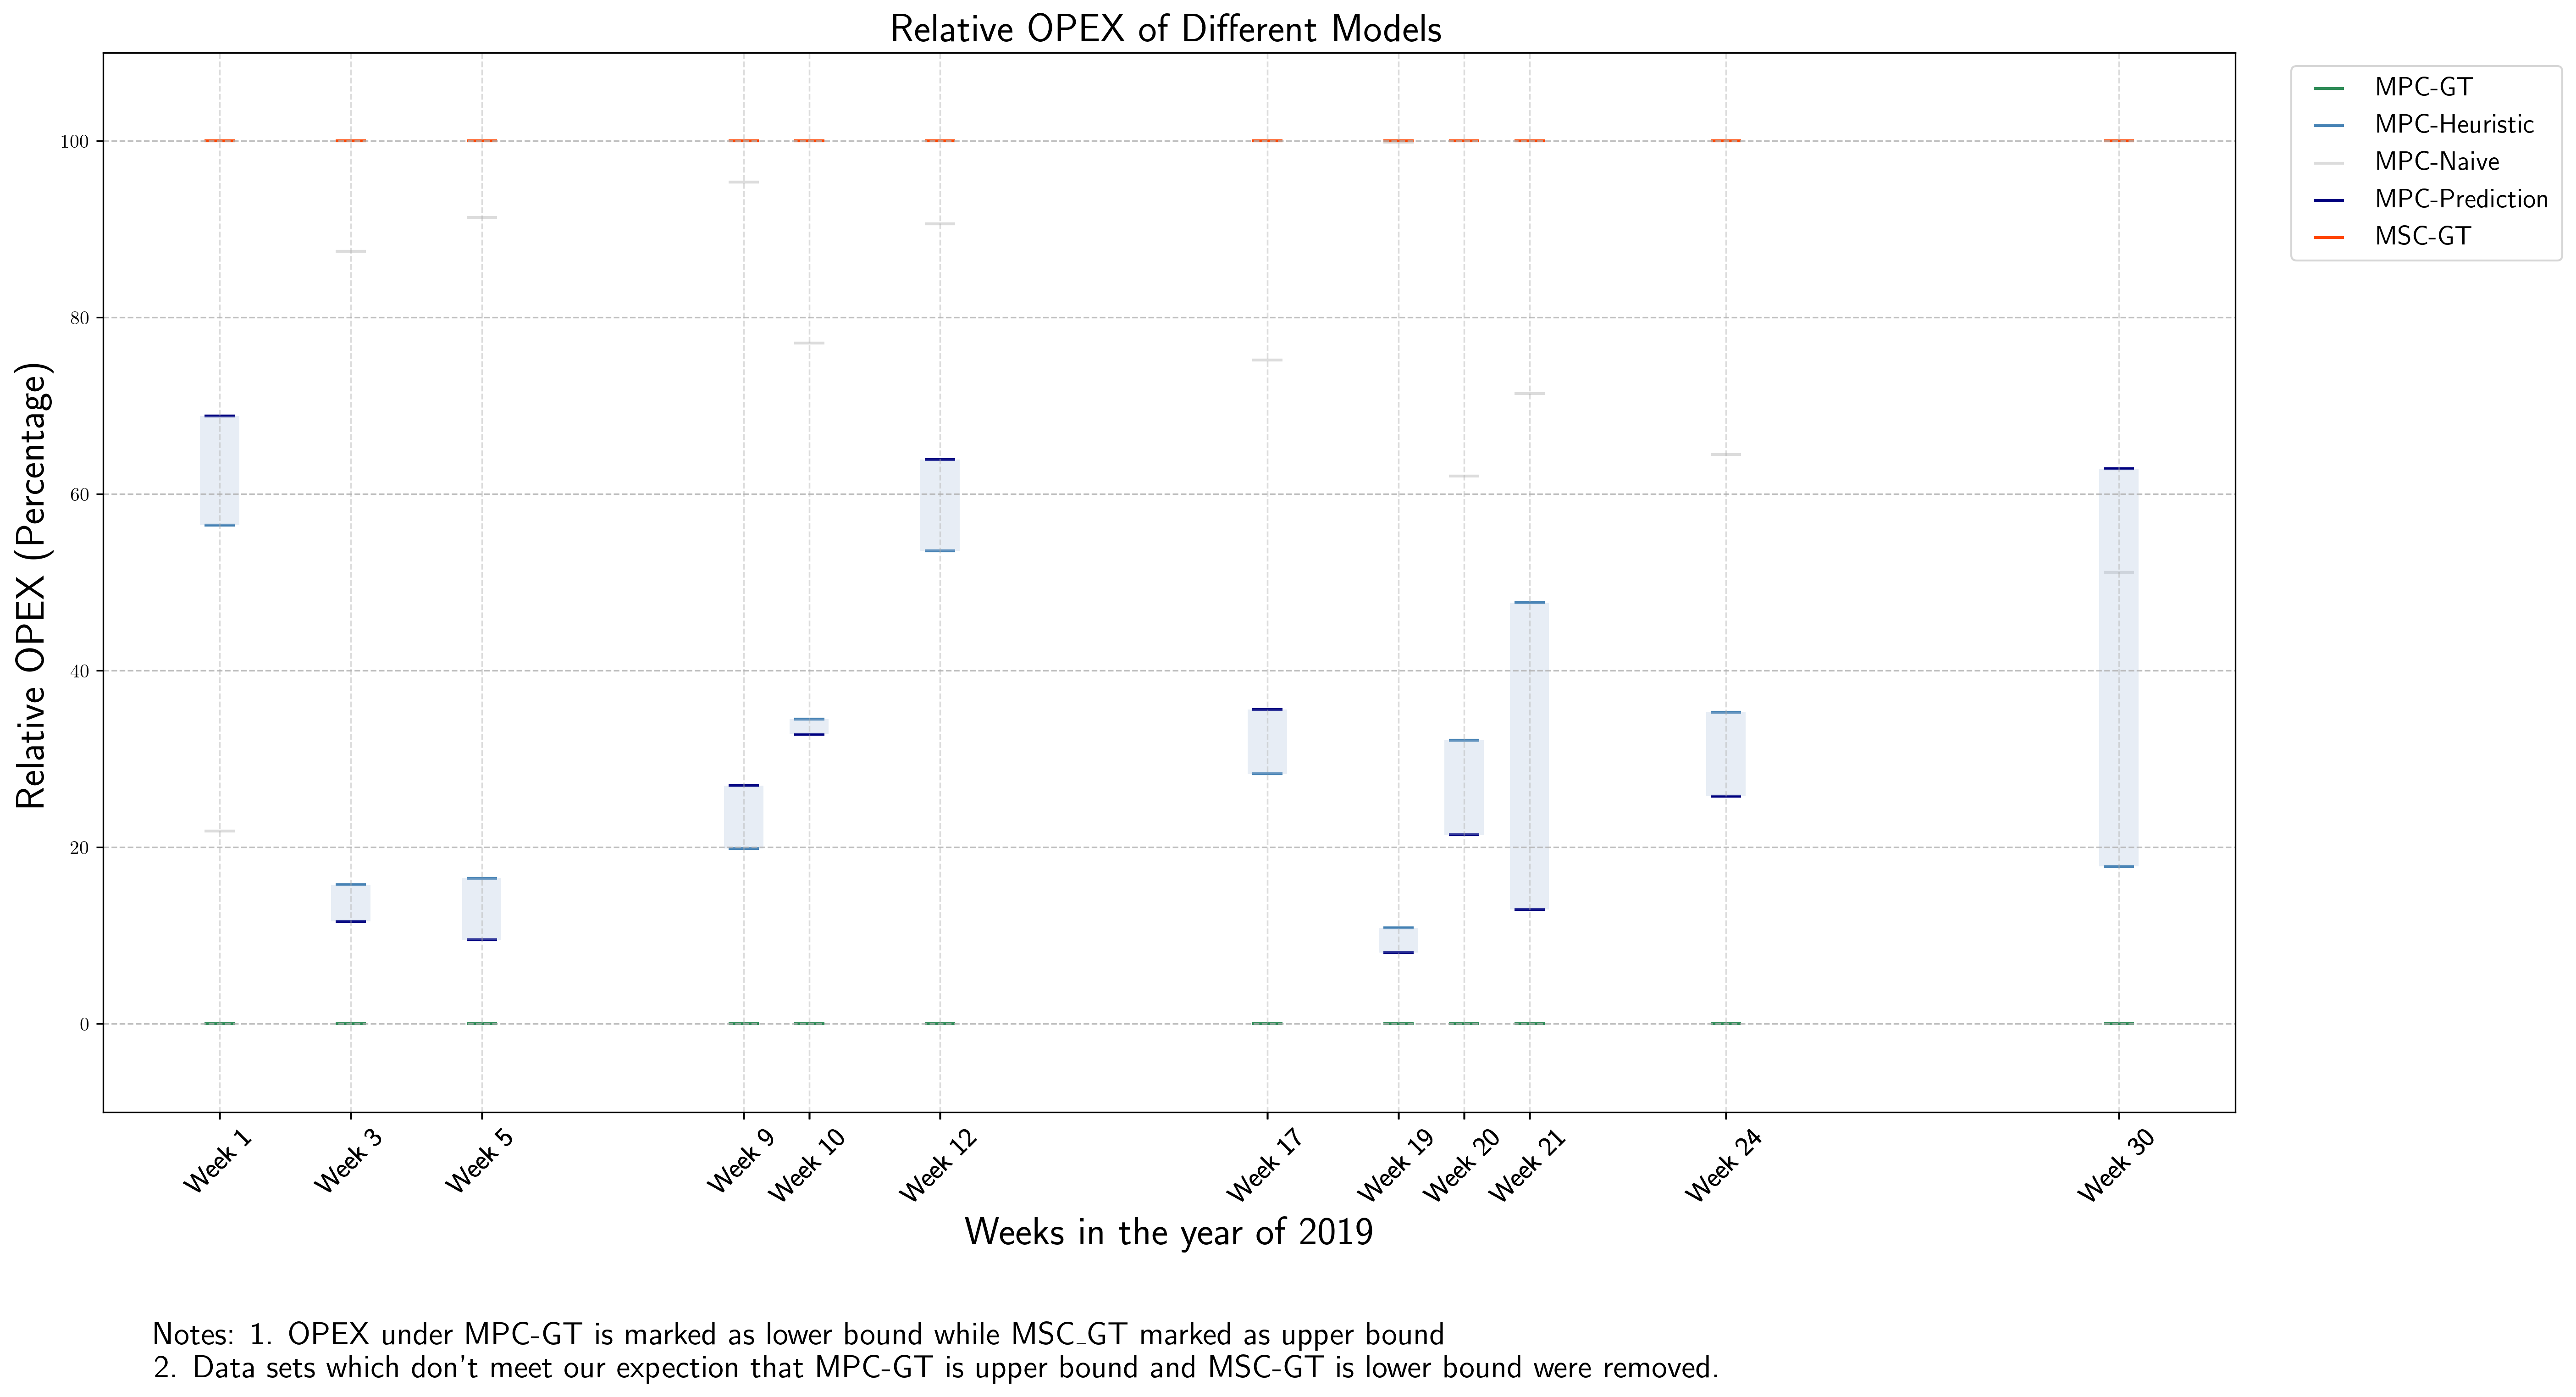

<Figure size 1920x1440 with 0 Axes>

In [27]:
plot_valid(df,limit,figsize,'relative_OPEX_byweek_orgin_dc_formulation_valid.png','OPEX',14)

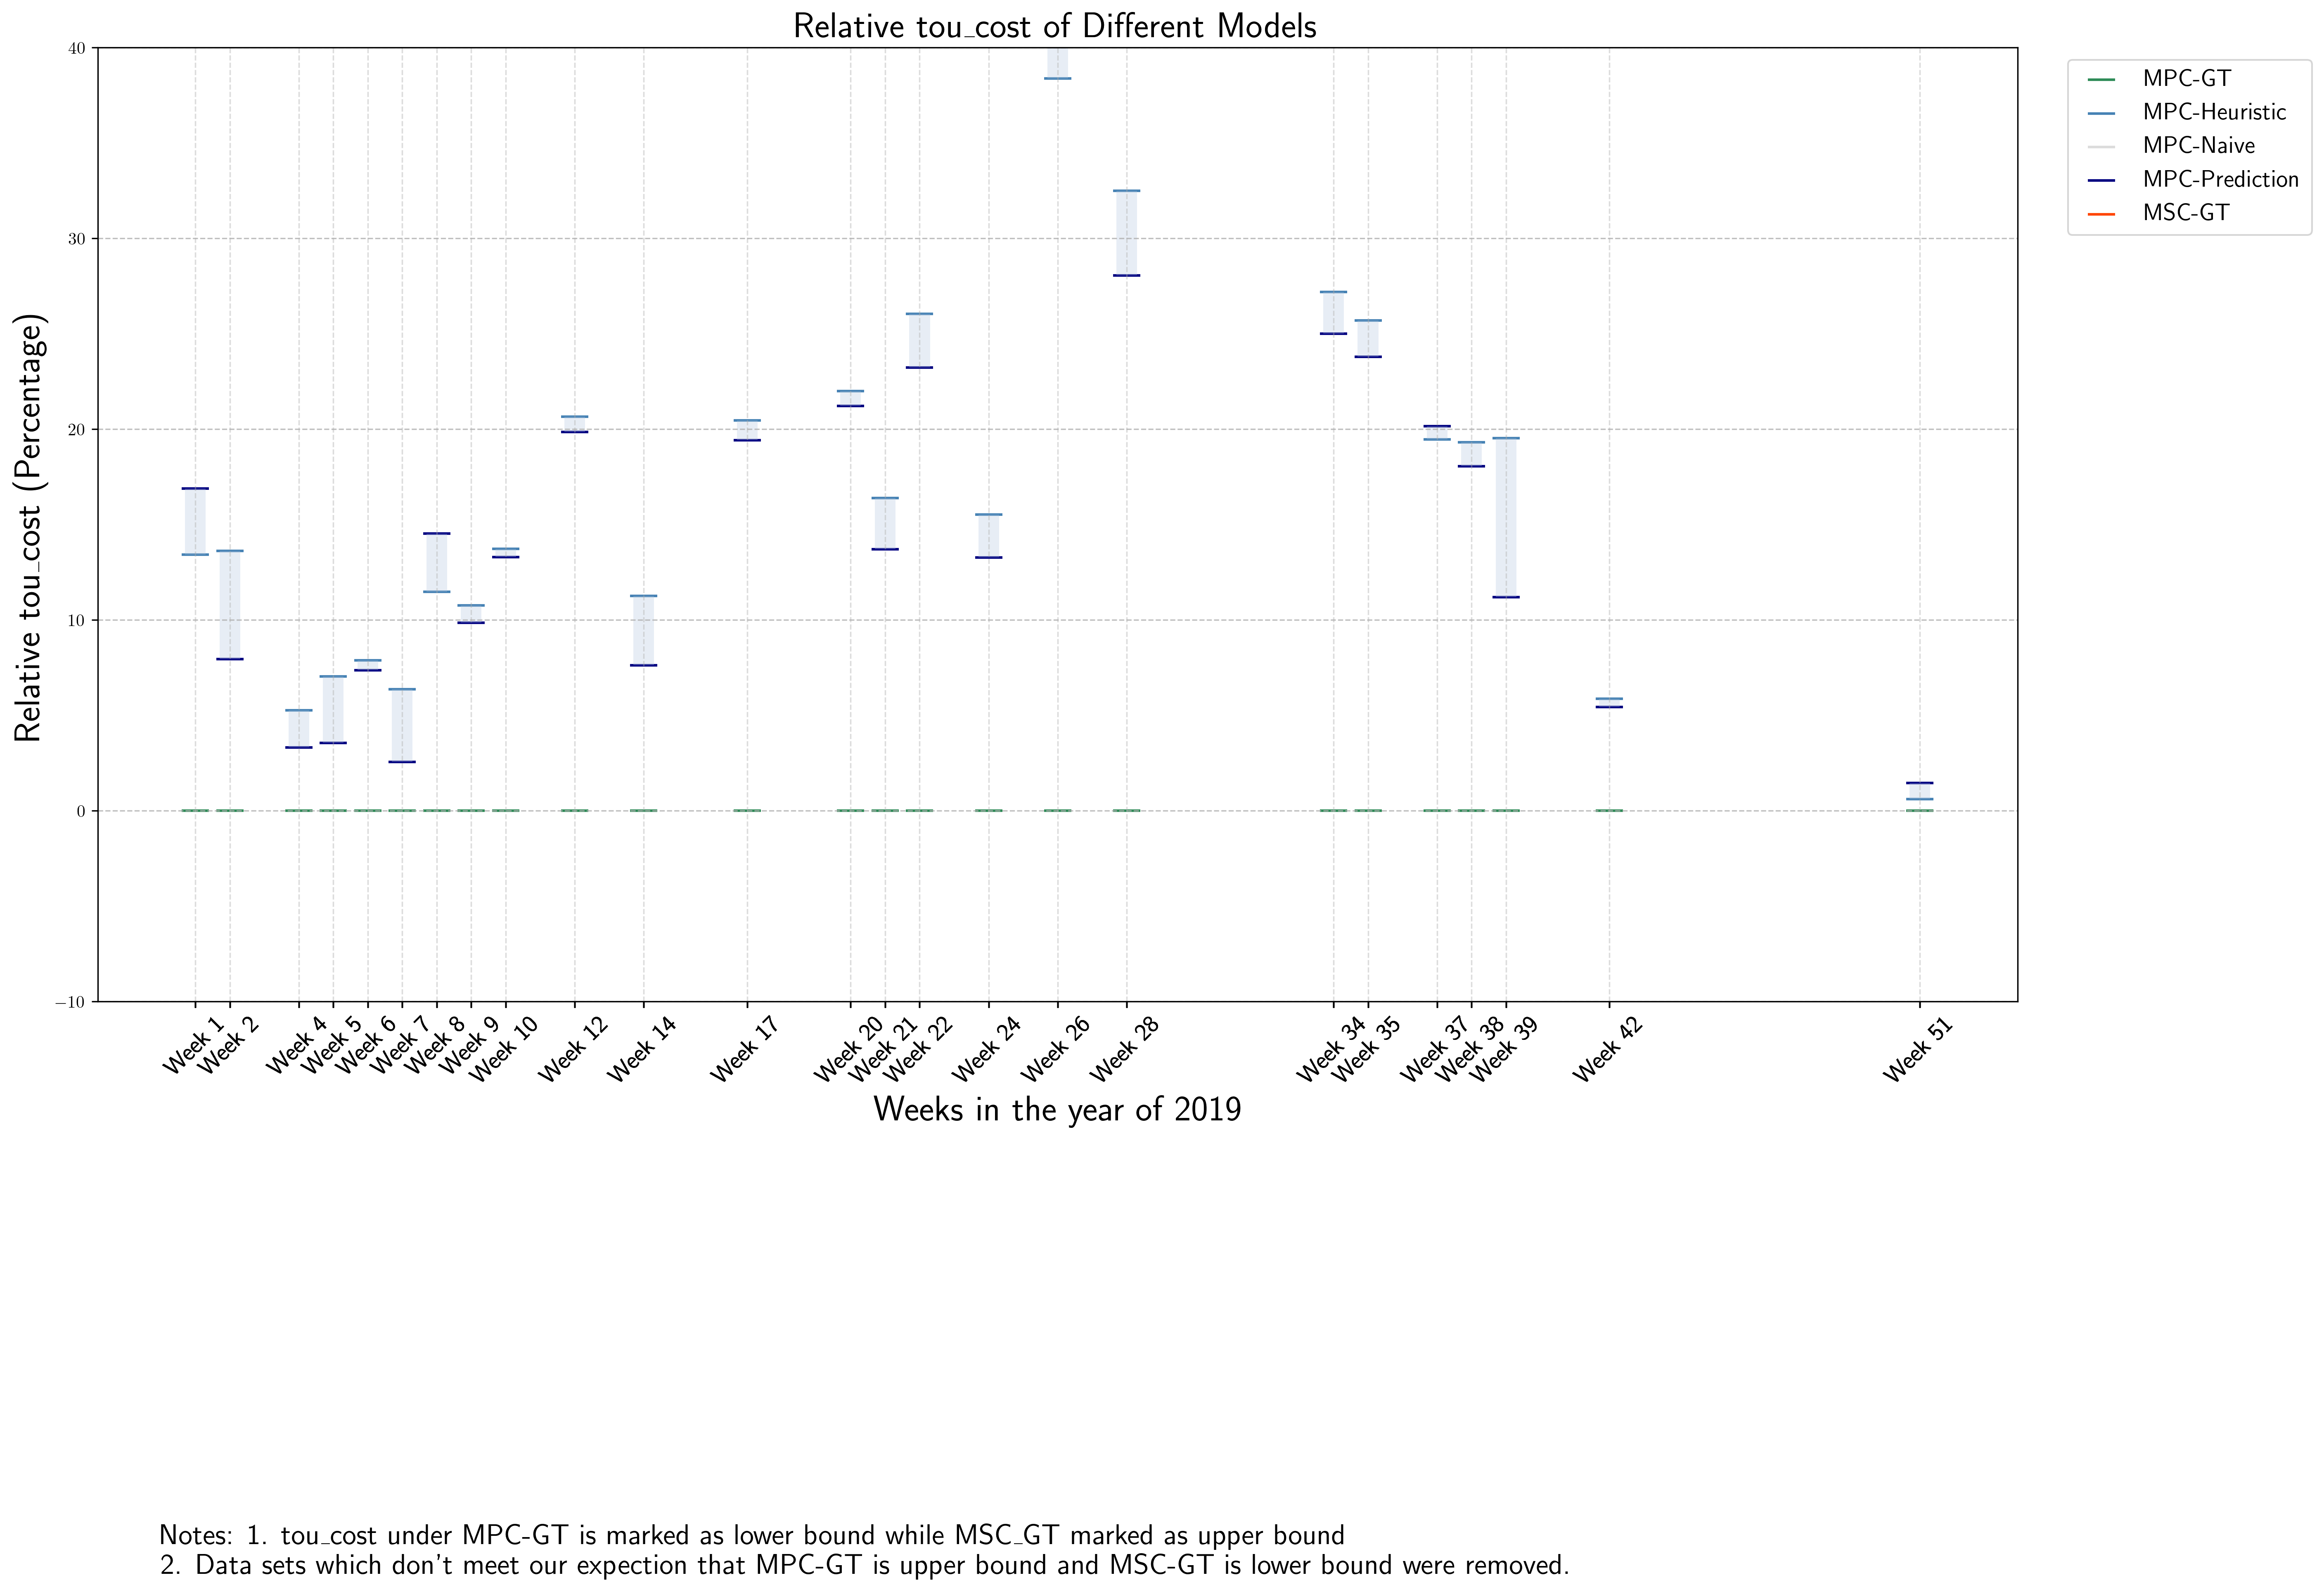

<Figure size 1920x1440 with 0 Axes>

In [17]:
limit=[-10,40]
plot_valid(df,limit,figsize,'relative_tou_cost_byweek_orgin_dc_formulation_valid.png','tou_cost',14)

In [5]:
metrics_steps=[1,2,3,4,5,6,7,8,9,10,11,12,24,36,48,60,72,84,96]
simple_metrics=[]
metric_keys={"MAE":[1,2,3,4,5,6,7,8,9,10,11,12,24,36,48,60,72,84,96],
             "MAPE":[1,2,3,4,5,6,7,8,9,10,11,12,24,36,48,60,72,84,96],
             #"RMSE":[1,2,3,4,5,6,7,8,9,10,11,12,24,36,48,60,72,84,96],
             }

for i in metric_keys.keys():
    for n in metric_keys[i]:
        simple_metrics.append(i+'_'+str(n))
    

prediction=Prediction_evaluation(
    abs_path=True,
    simple_path='D:/Codes/GIthub_repo/Energy_grid/data/load_forecast/Simple/BLD_sum_Simple_prediction.csv',
    xgb_path='D:/Codes/GIthub_repo/Energy_grid/data/load_forecast/XGB/BLD_sum_XGBoost_prediction.csv',
    type='BLD',
    name=None,
    simple_metrics=simple_metrics,
    scale_coef=1,
    group_method='week'
)

Notification: data type of simple predeiction:
object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35142 entries, 0 to 35141
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DateTime                  35142 non-null  datetime64[ns]
 1   RealPower                 35136 non-null  float64       
 2   RealPower_before_scaling  35136 non-null  float64       
 3   Pred_Simple               35142 non-null  object        
 4   historical_ave            35041 non-null  float64       
 5   future_real               35142 non-null  object        
 6   MAE_1                     35041 non-null  float64       
 7   RMSE_1                    35041 non-null  float64       
 8   MAPE_1                    35041 non-null  float64       
 9   MAE_2                     35041 non-null  float64       
 10  RMSE_2                    35041 non-null  float64       
 11  MAPE_2                    

In [6]:
eva=prediction.metrics_by_duration()

              RealPower  RealPower_before_scaling  historical_ave     MAE_1  \
week_of_year                                                                  
1             57.694079                576.940793       67.979936  1.305095   
2             77.084008                770.840077       63.925179  1.639685   
3             78.916673                789.166734       64.014427  1.822814   
4             76.789226                767.892257       67.338983  1.525425   
5             80.812720                808.127199       73.637195  1.369859   
6             79.746932                797.469320       78.400657  1.236560   
7             78.422592                784.225920       79.066388  1.247278   
8             77.061975                770.619747       78.942867  1.336317   
9             80.770344                807.703445       79.011055  1.297336   
10            80.611952                806.119522       79.000461  1.272479   
11            81.550012                815.500116   

In [7]:
opex=pre_process(df)

In [48]:
def plot_eva_scatter(df,metric,steps,limit):
    
    plt.style.use("_mpl-gallery-nogrid")

    key_list=[]
    for i in steps:
        key_list.append(metric+'_'+str(i))
    
    color_dict={
        'MPC-GT':'seagreen',
        'MPC-Prediction':'navy',
        'MPC-Heuristic':'steelblue',
        'MPC-Naive':'gainsboro',
        'MSC-GT':'orangered',
        'MSC-Naive':'grey'
    }
    maker_dict={
        'MPC-GT':'_',
        'MPC-Prediction':'_',
        'MPC-Heuristic':'_',
        'MPC-Naive':'_',
        'MSC-GT':'_',
        'MSC-Naive':'_'
    }
    if metric=='MAPE':
        scale=100
        unit='(percentage)'
    else:
        scale=1
        unit='(kW)'
    fig,ax=plt.subplots(figsize=(20,5))
    scatter_x=np.array(df['week_of_year'])
    #scatter_y=np.array(df[new_key])

    label_x=[]
    for i in scatter_x: 
        label_x.append('Week '+str(i))
    ax.set_xticks(ticks=scatter_x)
    ax.set_xticklabels(labels=label_x,fontsize=10,rotation=45)
    
    
    i=1
    for g in key_list:
        i=i+1
        ax.scatter(np.array(df['week_of_year']), np.array(df[g]*scale), label=g,\
            marker='x',s=60,cmap=plt.get_cmap('viridis'))
    ax.scatter(np.array(df['week_of_year']), np.array(df[metric+"_XGB"]), label=metric+"_XGB",\
            marker='_',s=250,c='orangered')    
    
    ax.set_ylim(limit)
    ax.legend(loc='upper left',bbox_to_anchor=(1.02,1))

    ax.set_xlabel("Weeks in the year of 2019",fontsize=10)
    ax.set_ylabel(metric+unit,fontsize=10)


    ax.set_title("Prediction Metrics("+metric+") of XGB and Heuristic",fontsize=15)
    
    '''ax.text(s="Notes: 1. OPEX under MPC-GT is marked as lower bound while MSC_GT marked as upper bound.",
            fontsize=12,
            x=0,
            y=-65
            )'''
    #ax.grid(True)
    plt.show()

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_24724\3693241771.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(np.array(df['week_of_year']), np.array(df[g]*scale), label=g,\


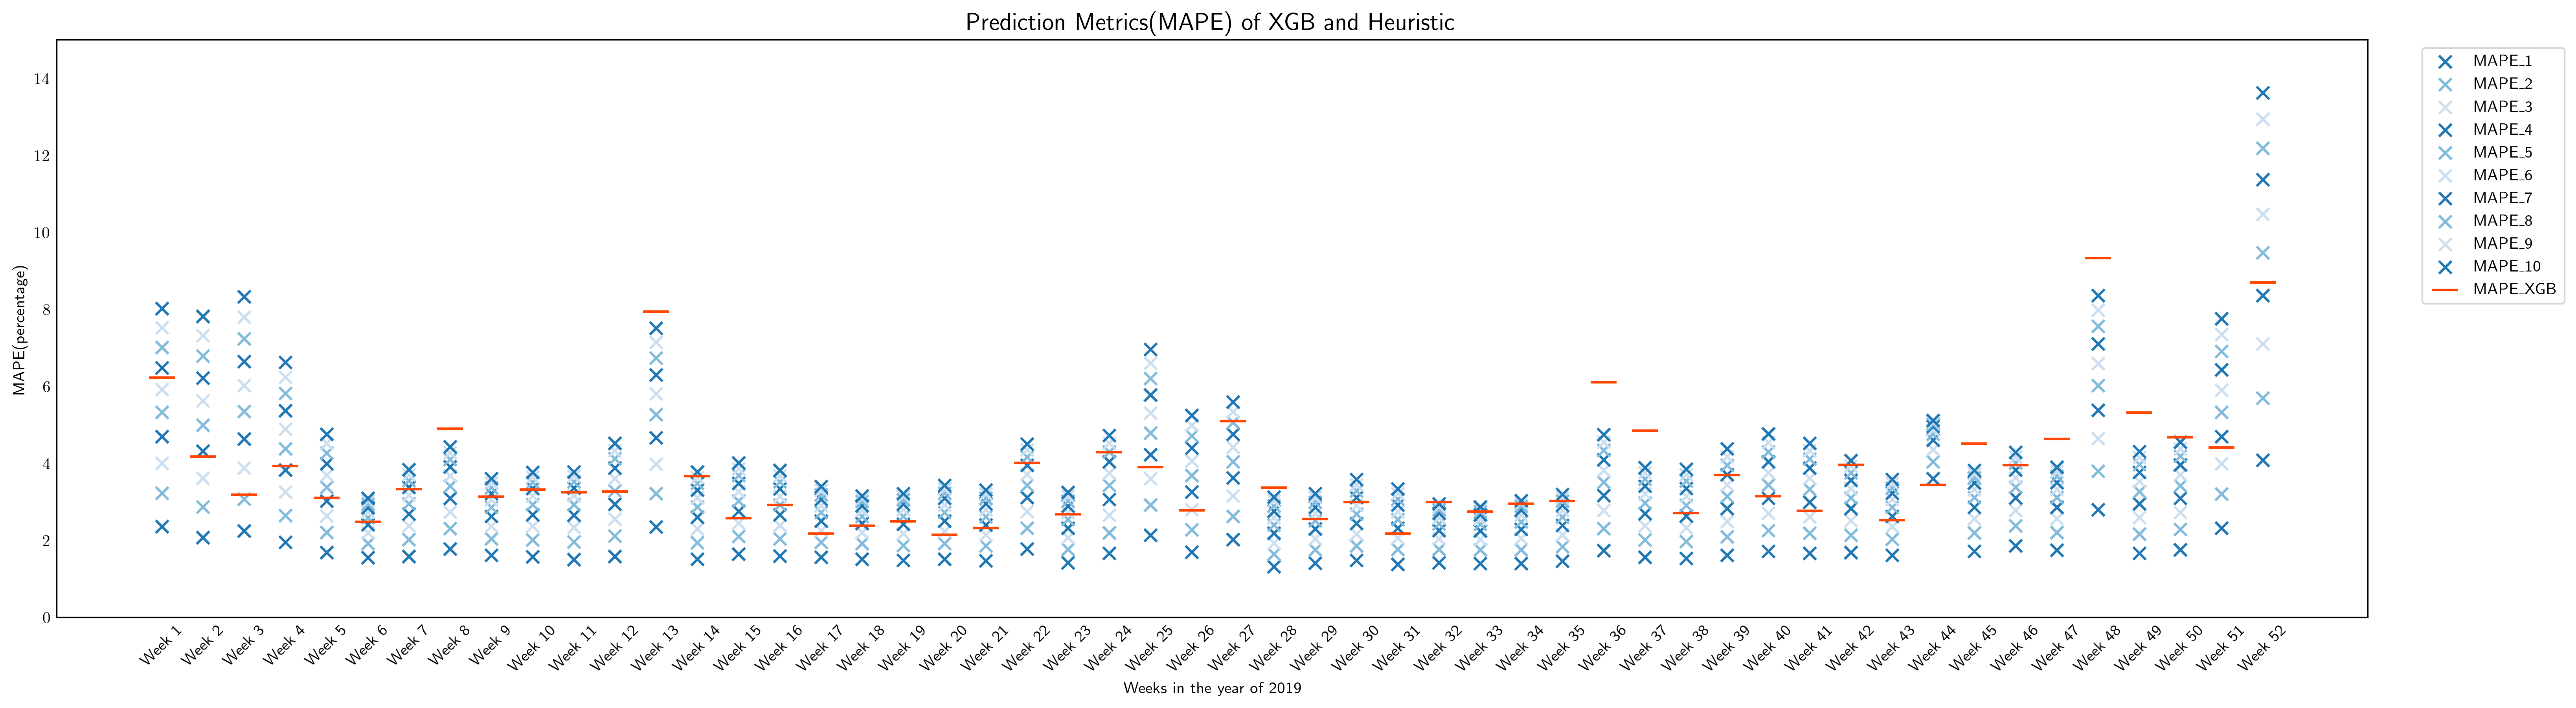

In [52]:
metric='MAPE'
steps=[1,2,3,4,5,6,7,8,9,10]
limit=[0,15]
plot_eva_scatter(eva.reset_index().copy(),metric,steps,limit)

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_24724\3693241771.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(np.array(df['week_of_year']), np.array(df[g]*scale), label=g,\


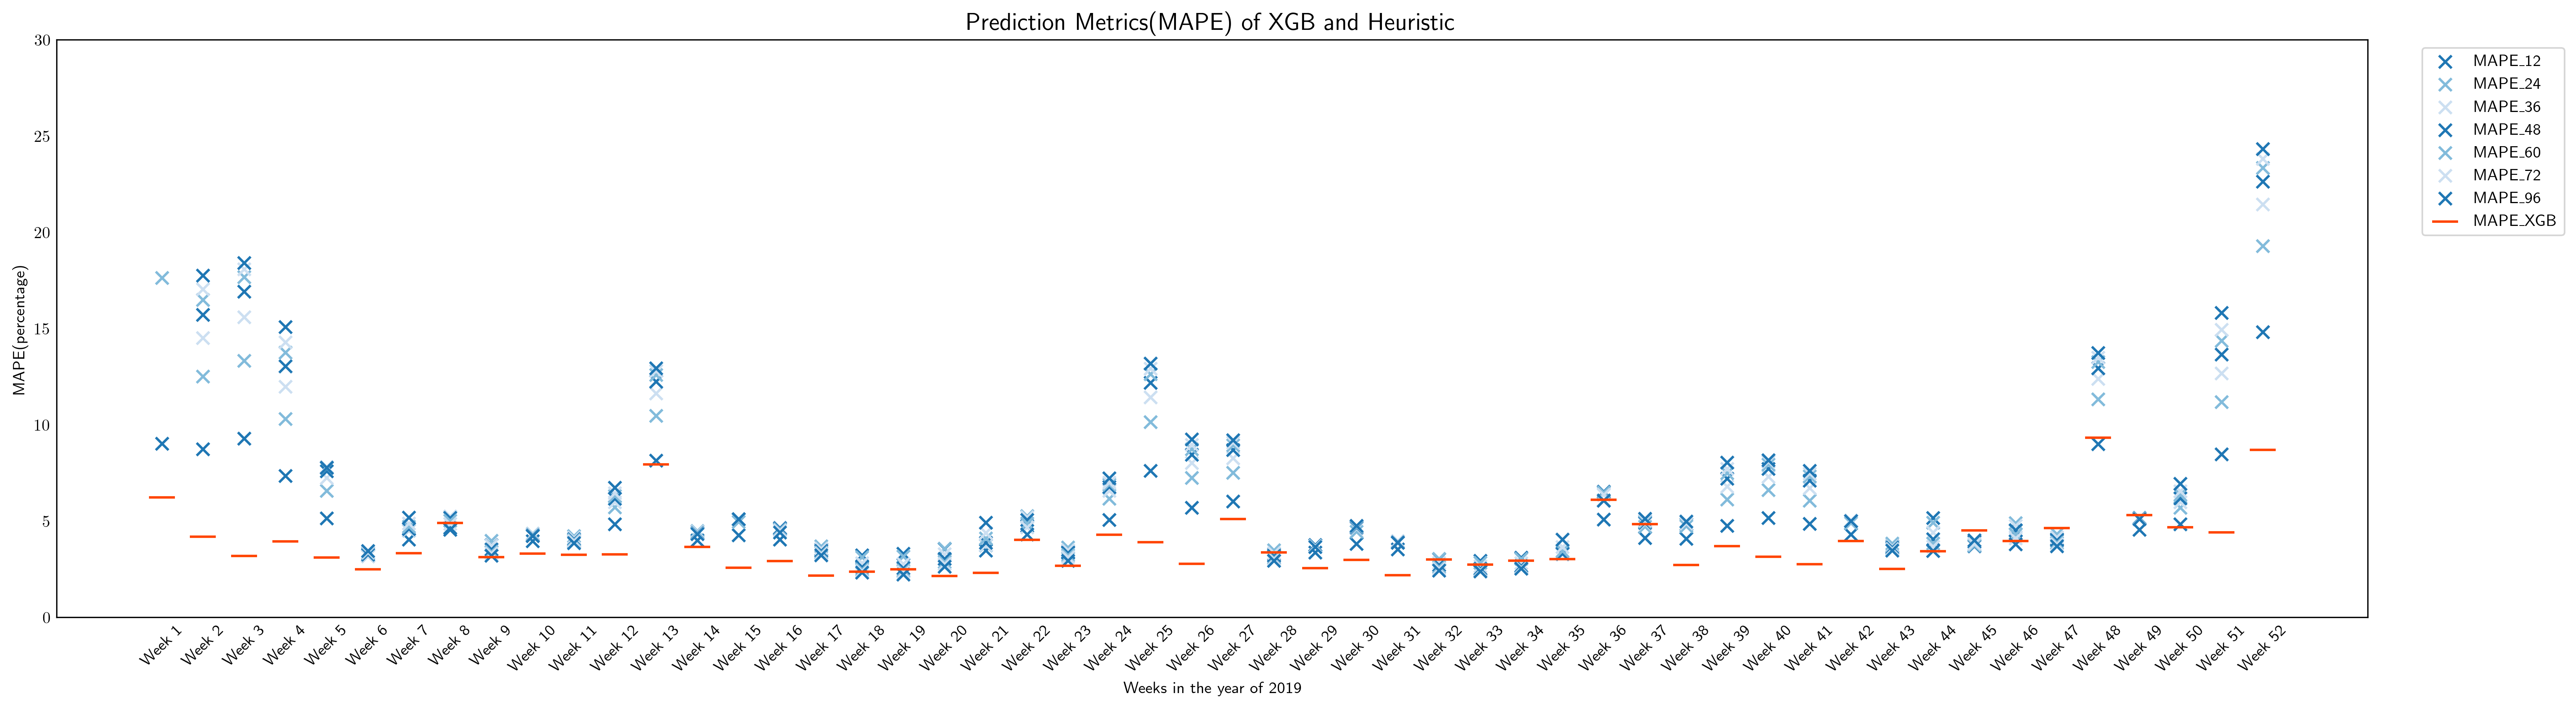

In [49]:
metric='MAPE'
steps=[12,24,36,48,60,72,96]
limit=[0,30]
plot_eva_scatter(eva.reset_index().copy(),metric,steps,limit)

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_24724\3693241771.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(np.array(df['week_of_year']), np.array(df[g]*scale), label=g,\


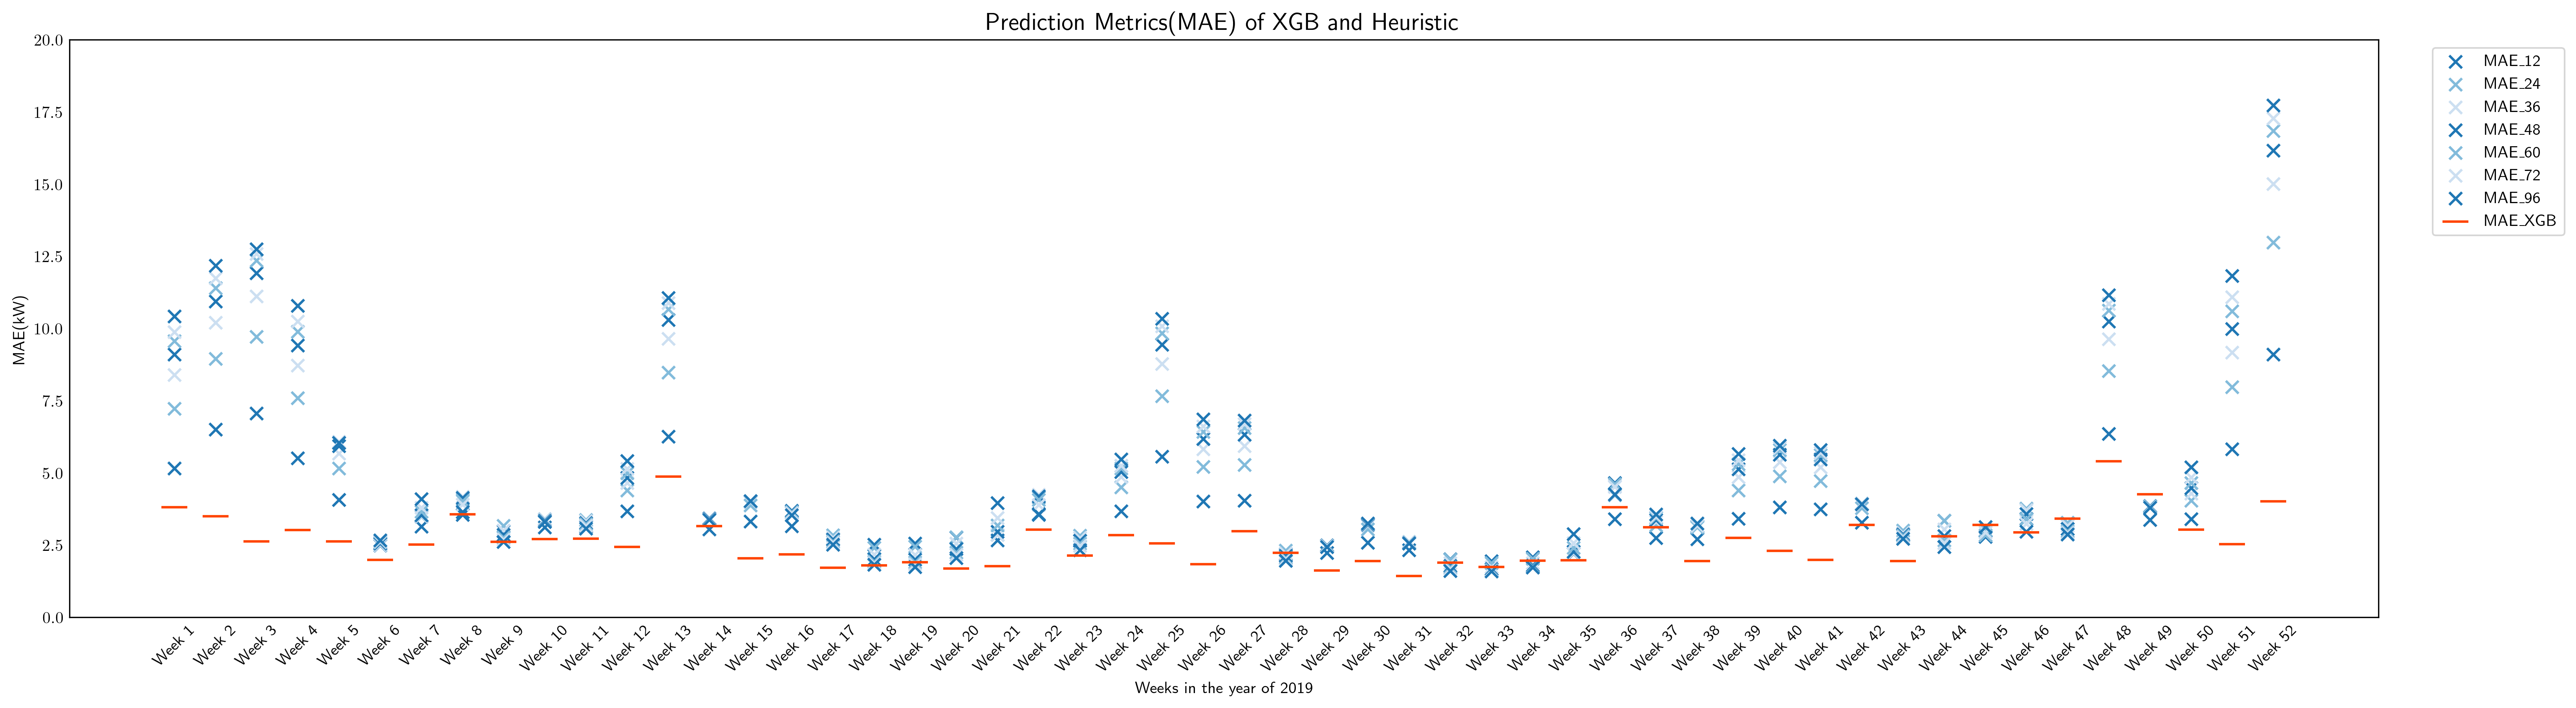

In [50]:
metric='MAE'
steps=[12,24,36,48,60,72,96]
limit=[0,20]
plot_eva_scatter(eva.reset_index().copy(),metric,steps,limit)

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_24724\3693241771.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(np.array(df['week_of_year']), np.array(df[g]*scale), label=g,\


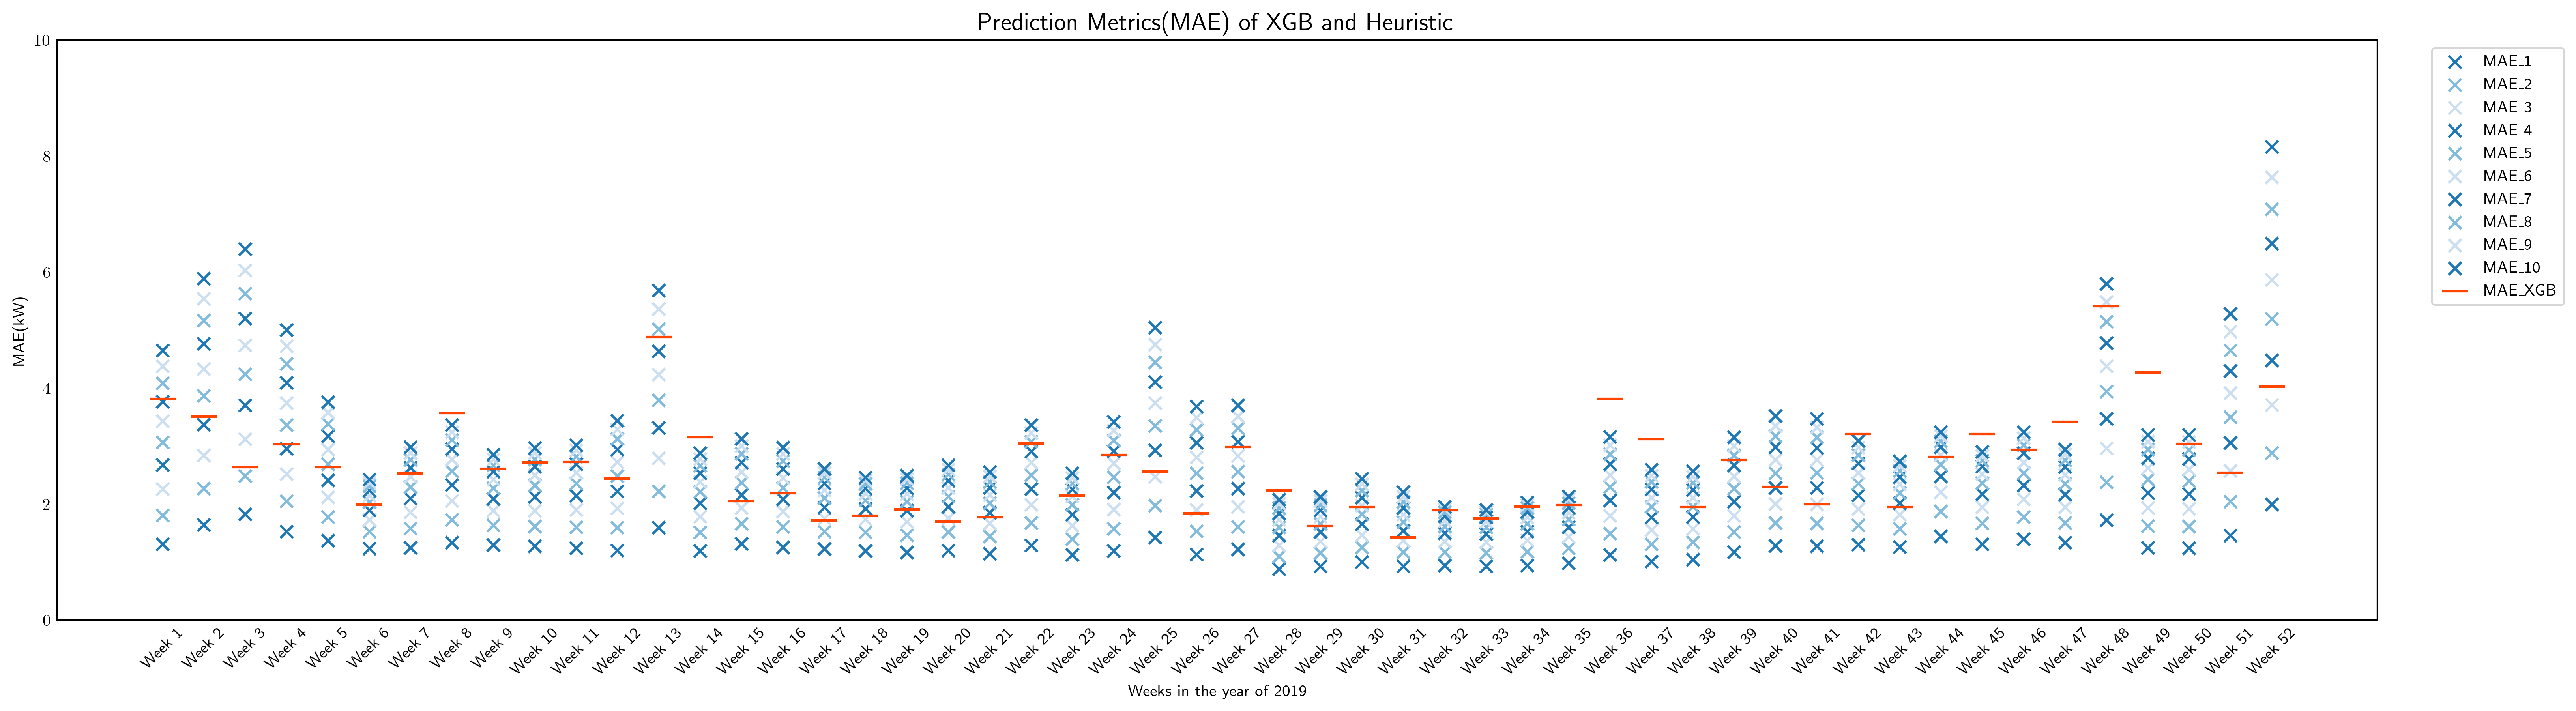

In [53]:
metric='MAE'
steps=[1,2,3,4,5,6,7,8,9,10]
limit=[0,10]
plot_eva_scatter(eva.reset_index().copy(),metric,steps,limit)

In [57]:
merged_df=pd.merge(opex,eva,on='week_of_year',how='inner')

In [58]:
merged_df_grouped=merged_df.groupby("label")

In [27]:
merged_df_grouped.get_group('MPC-Heuristic')

,strategy,pred_model,week_of_year,OPEX,label,relative_OPEX,is_valid,RealPower,RealPower_before_scaling,historical_ave,...,MAE_84,RMSE_84,MAPE_84,MAE_96,RMSE_96,MAPE_96,Pred_XGB,MSE_XGB,MAE_XGB,MAPE_XGB
2,MPC,Heuristic,1,246.395900,MPC-Heuristic,57.812626,True,57.694079,576.940793,67.979936,...,10.159563,11.761173,52.828605,10.419602,12.119795,179.624358,58.380672,32.409294,3.812005,6.230080
7,MPC,Heuristic,2,392.668735,MPC-Heuristic,43.539309,False,77.084008,770.840077,63.925179,...,11.995983,14.214589,0.174570,12.186215,14.527404,0.177693,75.085441,35.857292,3.502198,4.179573
12,MPC,Heuristic,3,460.970540,MPC-Heuristic,11.705854,False,78.916673,789.166734,64.014427,...,12.708011,14.795189,0.183153,12.750841,14.924883,0.184164,77.897389,13.064593,2.635898,3.189267
17,MPC,Heuristic,4,368.161066,MPC-Heuristic,63.465798,True,76.789226,767.892257,67.338983,...,10.542086,12.142162,0.147210,10.796540,12.465854,0.150867,75.299999,17.916931,3.028625,3.934940
22,MPC,Heuristic,5,NaN,MPC-Heuristic,NaN,False,80.812720,808.127199,73.637195,...,6.071252,6.906323,0.078231,6.038482,6.910588,0.077850,78.834669,13.001901,2.631936,3.101385
27,MPC,Heuristic,6,393.900968,MPC-Heuristic,-10.184965,False,79.746932,797.469320,78.400657,...,2.654013,3.164921,0.034351,2.664786,3.186915,0.034569,80.356969,6.716605,1.990288,2.486776
32,MPC,Heuristic,7,418.361466,MPC-Heuristic,92.641953,False,78.422592,784.225920,79.066388,...,3.952129,4.797151,0.050387,4.092447,5.012086,0.051941,79.021666,11.460690,2.525950,3.327262
37,MPC,Heuristic,8,385.296323,MPC-Heuristic,-2133.986934,False,77.061975,770.619747,78.942867,...,3.767983,4.586260,0.046950,3.647286,4.519011,0.045516,75.349519,20.283275,3.566827,4.903658
42,MPC,Heuristic,9,381.427679,MPC-Heuristic,-9.102004,False,80.770344,807.703445,79.011055,...,2.654686,3.366316,0.032587,2.613681,3.380346,0.032043,79.114960,11.156764,2.609723,3.137410
47,MPC,Heuristic,10,399.354457,MPC-Heuristic,69.316508,True,80.611952,806.119522,79.000461,...,3.306962,3.970451,0.042203,3.310671,4.012688,0.042228,79.325308,12.441316,2.714252,3.316054


In [67]:
def plot_scatter(df):
    color_dict={
        'MPC-GT':'seagreen',
        'MPC-Prediction':'navy',
        'MPC-Heuristic':'steelblue',
        'MPC-Naive':'gainsboro',
        'MSC-GT':'orangered',
        'MSC-Naive':'grey'
    }
    maker_dict={
        'MPC-GT':'_',
        'MPC-Prediction':'_',
        'MPC-Heuristic':'_',
        'MPC-Naive':'_',
        'MSC-GT':'_',
        'MSC-Naive':'_'
    }

    fig,ax=plt.subplots(figsize=(9,9))

    metric='MAPE'

    '''
    group=np.array(df['label'])
    label_x=[]
    for i in scatter_x: 
        label_x.append('Week '+str(i))
    ax.set_xticks(ticks=scatter_x)
    ax.set_xticklabels(labels=label_x,fontsize=10,rotation=45)
    '''
    
    color_list={
        'MAPE_4':'seagreen',
        #'MAPE_2':'navy',
        #'MAPE_3':'steelblue',
        #'MAPE_4':'gainsboro',
        #'MAPE_5':'orangered',
        #'MAPE_6':'grey'
        }

    for i in color_list.keys():    
        ax.scatter(np.array(df[i])*100, df[new_key],\
                marker='.',s=150,c=color_list[i])
    ax.set_ylim([-20,120])
    ax.legend(color_list.keys())
    
    ax.set_xlabel("MAPE(Percentage)",fontsize=10)
    ax.set_ylabel("Relative OPEX",fontsize=10)


    ax.set_title("Prediction Metrics("+metric+") of Heuristic and Relative OPEX",fontsize=15)

    '''
    ax.set_title("Relative OPEX of Different Models",fontsize=15)
    ax.text(s="Notes: 1. OPEX under MPC-GT is marked as lower bound while MSC_GT marked as upper bound.",
            fontsize=12,
            x=0,
            y=-65
            )
        
    '''
    #ax.grid(True)
    plt.show()

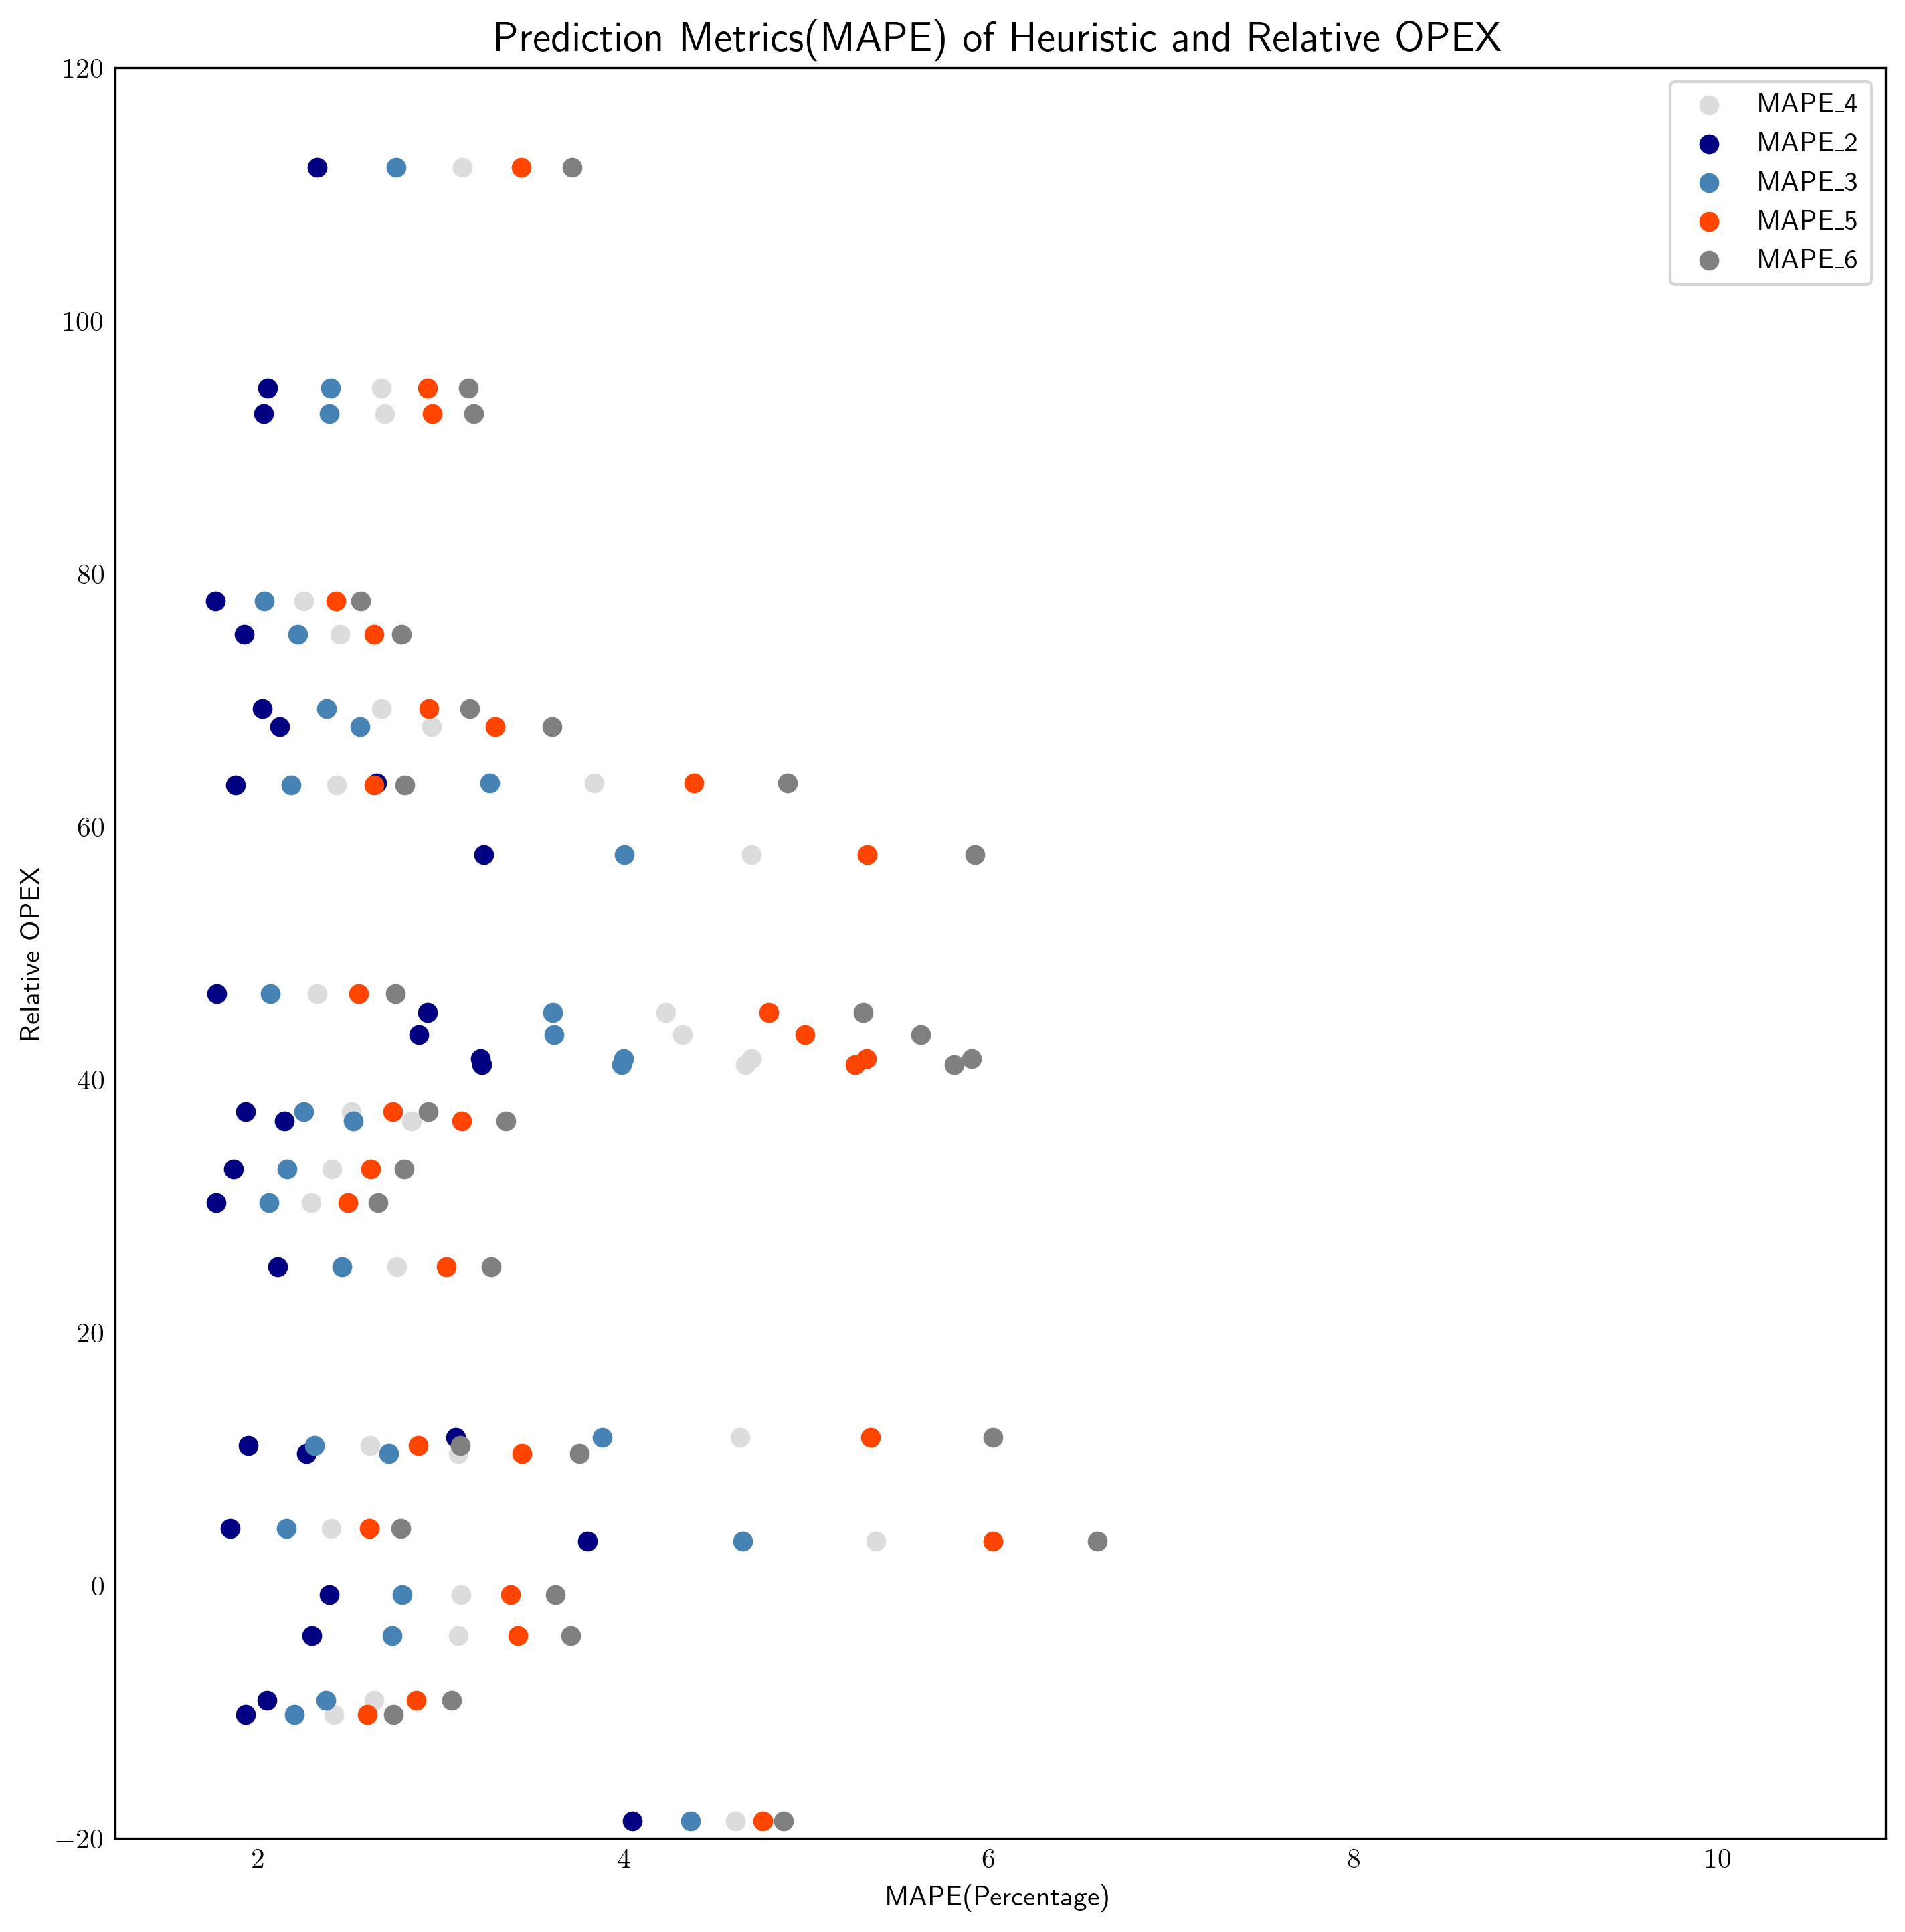

In [65]:
plot_scatter(merged_df_grouped.get_group('MPC-Heuristic'))

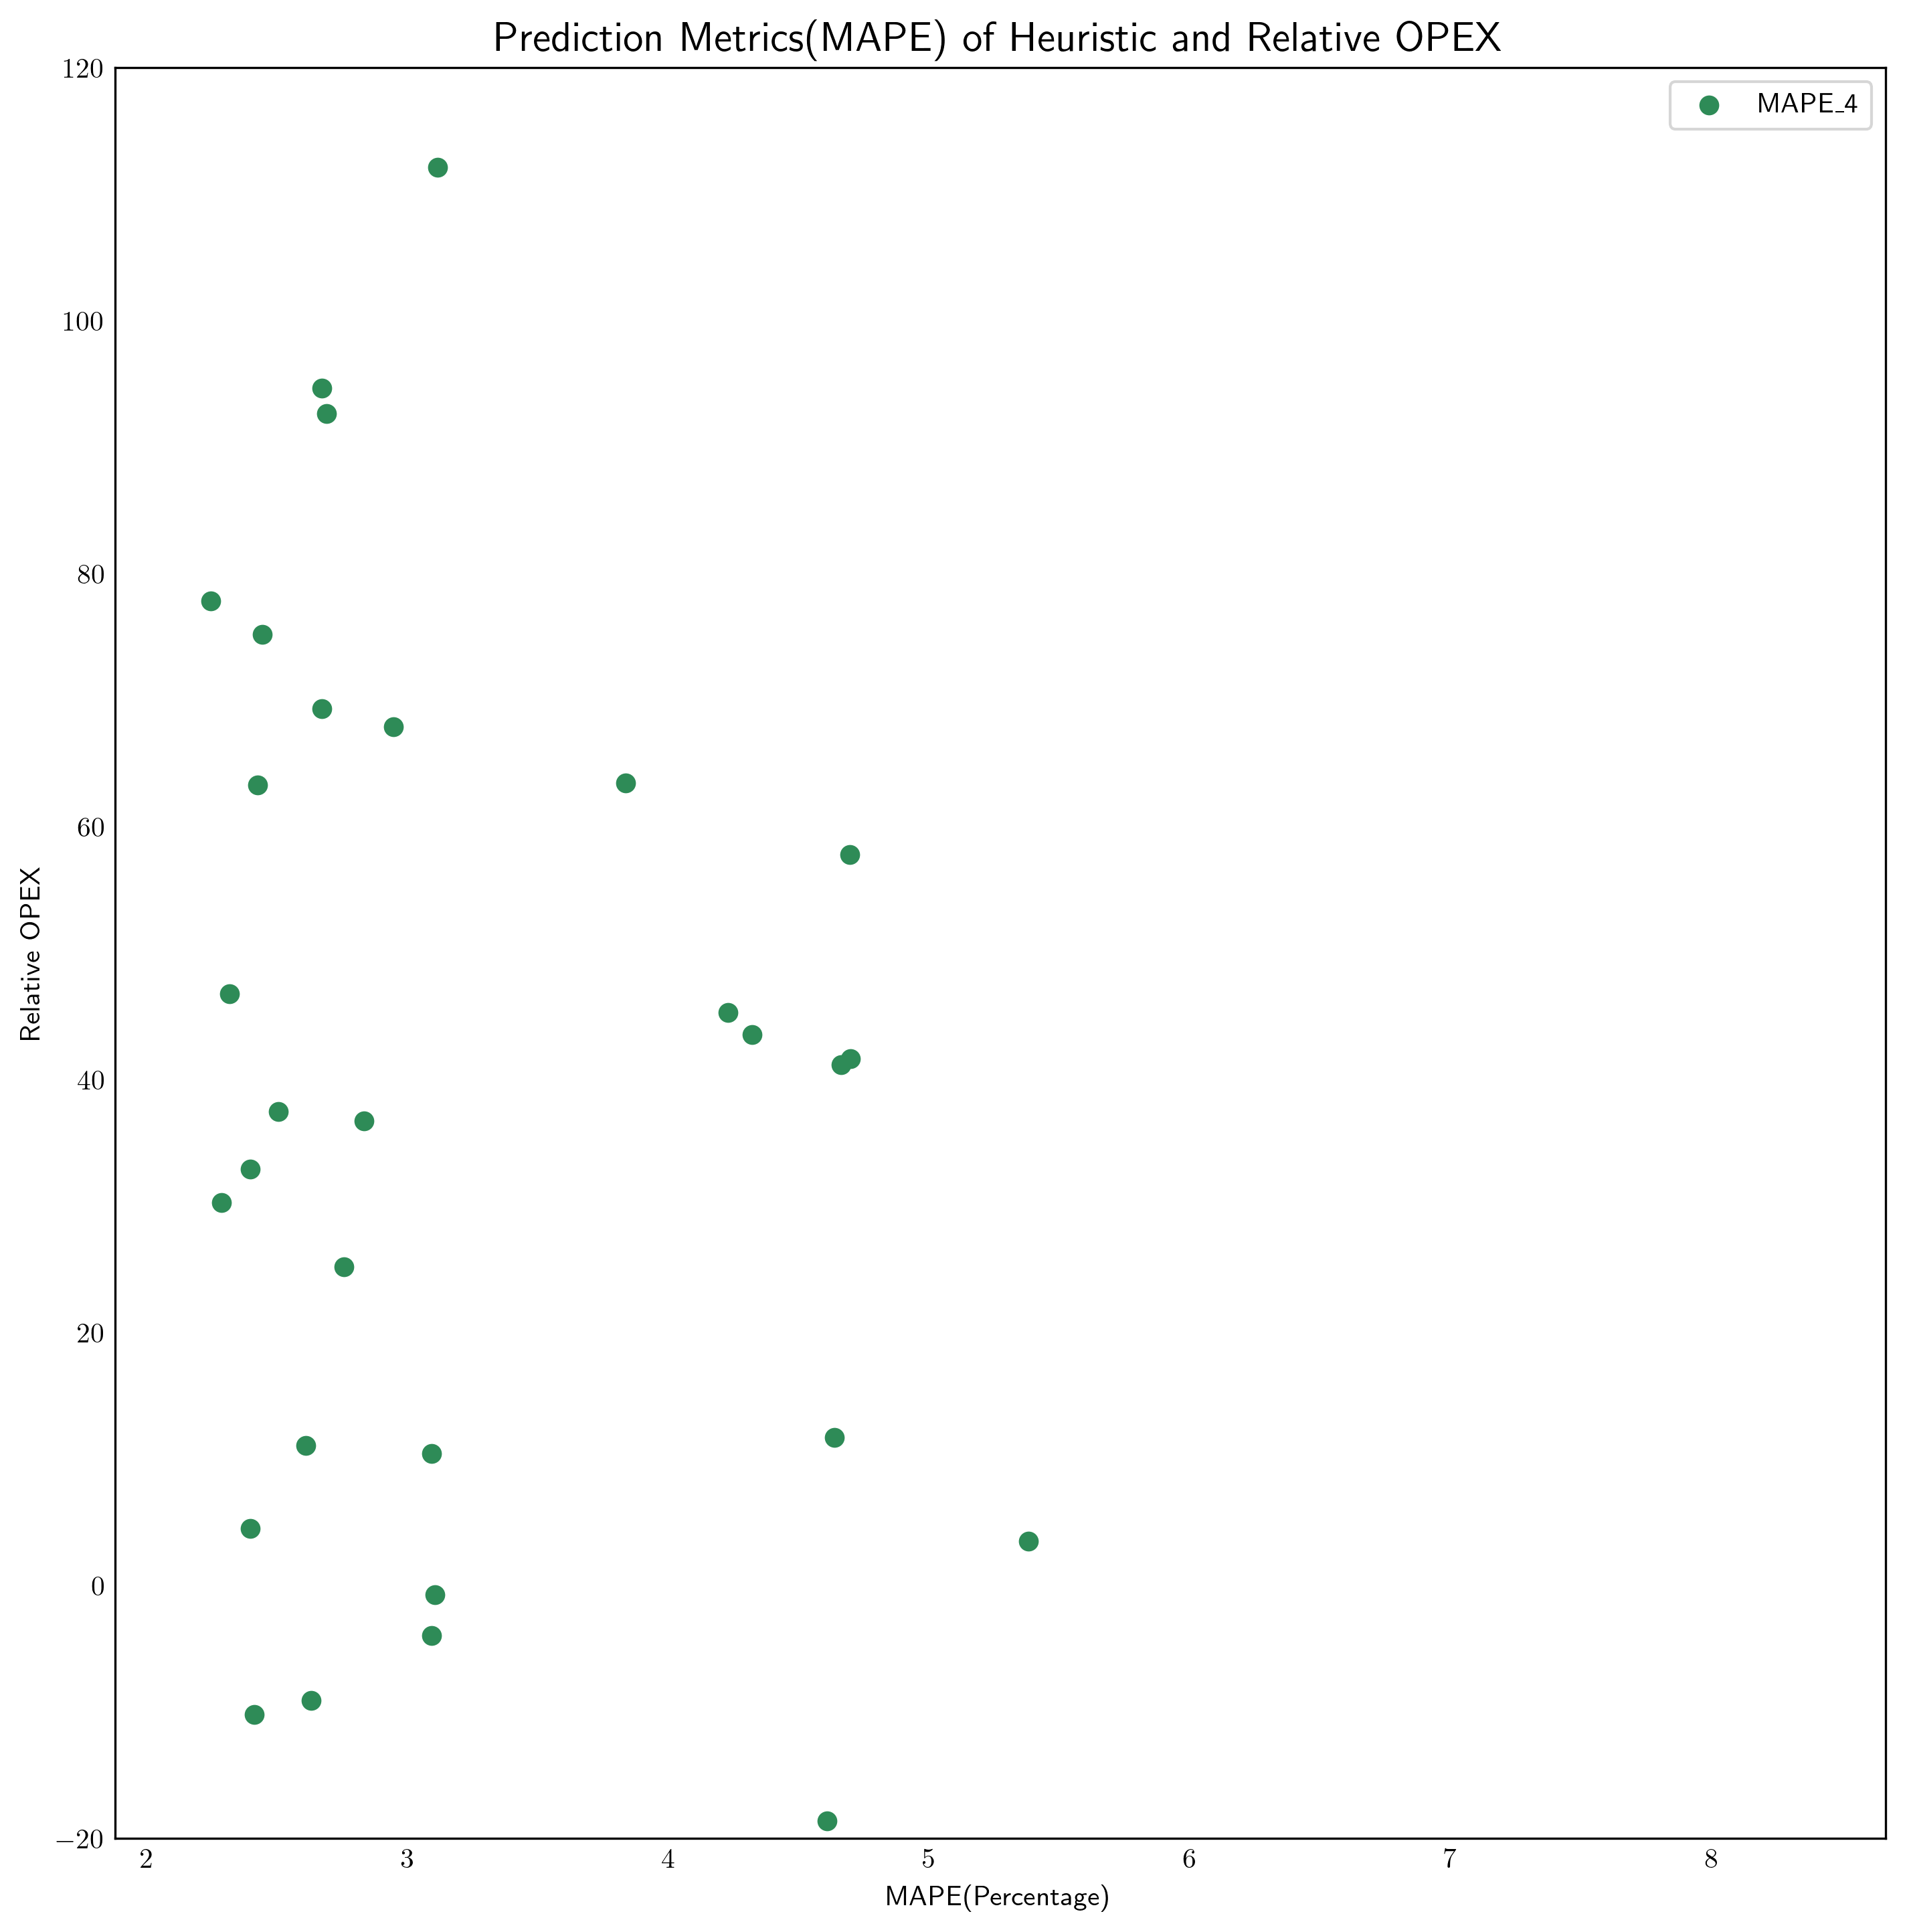

: 

In [68]:
plot_scatter(merged_df_grouped.get_group('MPC-Heuristic'))